# Simulate data using behavioral model and perform parameter recovery

There are 3 models with different parameter combinations:

1. <b>The Bayesian model (Schwöbel et al. 2021):</b> \
   <b>a.</b> With 3 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, and a decision temparature $\beta$. \
   <b>b.</b> With 4 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, a decision temparature $\beta$, and a habitual tendency $h$.
2. <b>A newer MF/MB version that is better for fitting (Otto et al. 2013):</b> \
<b>Note:</b> This is not quite the original version, as the Q-values in the original work did not converge to the true expected values. Instead, I implemented a "bug-fixed" version.\
   <b>a.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$$, and a repetition/perserveration parameter $p$. \
3. <b>The original model-free/model-based (MF/MB) model (Daw et al. 2005, 2011):</b> \
   <b>a.</b> With 4 parameters: a weighting parameters $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a weighting parameter $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, a dicount factor $\lambda$, and a repetition/perserveration parameter $p$.

Tell python that the code in the submodule is code that we want to import and run

In [12]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf
import inference_utils as iu

Other imports that we need for simulation, inference, and plotting

In [13]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
#import jsonpickle as pickle
import json
import gc
import pickle

Where second stage random walks from the experiment are stored

In [14]:
Rho_data_fname = os.path.join(current_dir, "experiment", "dawrandomwalks.mat")

Define where results should be saved

In [15]:
results_folder = os.path.join(current_dir, "results")
simulation_folder = os.path.join(results_folder, "simulations")
recovery_folder = os.path.join(results_folder, "recovery")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join("processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

#### Global experiment parameters

In [16]:
# number of simulated agents/participants
n_agents = 50

In [17]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_28957/1544998221.py:15: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


Define states and transition matrices

In [18]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

Load and plot reward probabilities

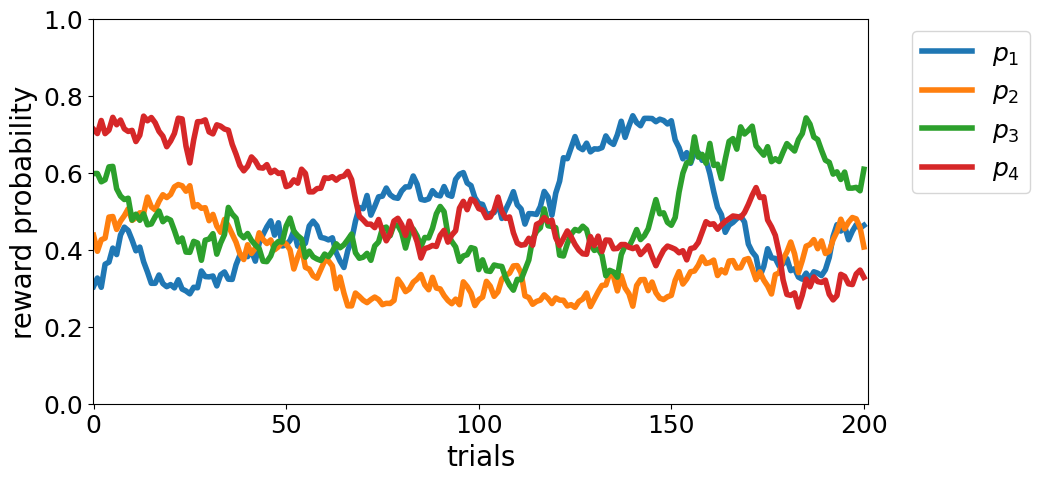

In [19]:
rew_probs = loadmat(Rho_data_fname)['dawrandomwalks']
assert trials==rew_probs.shape[-1]

Rho = torch.zeros((trials, nr, ns))

Rho[:,1,:never_reward] = 0.
Rho[:,0,:never_reward] = 1.

Rho[:,1,never_reward:never_reward+2] = torch.from_numpy(rew_probs[0,:,:]).permute((1,0))
Rho[:,0,never_reward:never_reward+2] = torch.from_numpy(1-rew_probs[0,:,:]).permute((1,0))

Rho[:,1,never_reward+2:] = torch.from_numpy(rew_probs[1,:,:]).permute((1,0))
Rho[:,0,never_reward+2:] = torch.from_numpy(1-rew_probs[1,:,:]).permute((1,0))

plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(Rho[:,1,3+i], label="$p_{}$".format(i+1), linewidth=4)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=18)
plt.ylabel("reward probability", fontsize=20)
plt.xlim([-0.1, trials+0.1])
plt.xticks(range(0,trials+1,50),fontsize=18)
plt.xlabel("trials", fontsize=20)
plt.legend(fontsize=18, bbox_to_anchor=(1.04,1))
plt.savefig(os.path.join(results_folder, "twostep_prob.svg"),dpi=300)
plt.show()

# add to parameter dict
global_experiment_parameters["Rho"] = Rho

Now we can start :) 

### 1. BCC:
### 1.a 3 parameter version

Simulation pre-setup

In [20]:
# set parameters and their names

learn_rewards = True
learn_habit = False
use_h = False
learn_cached = True

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str
print(agent_type)
fname_base = agent_type+"_simulation_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(simulation_folder,fname_base[:-1])

BCC_4pars_plan_cached
BCC_4pars_plan_cached_simulation_


<b>Decide</b> for running or loading simulated data

In [21]:
run_simulation = True

<b>Either:</b> (re)run simulations, save parameter and behavior

In [22]:
if run_simulation:
    # make directory if it doesnt exist
    if fname_base[:-1] not in os.listdir(simulation_folder):
        os.mkdir(base_dir)
    
    # choose whether olf simulations in this folder should be deleted.
    remove_old = True

    print("simulating "+str(n_agents)+" agents...\nrandomly generating true parameter values...")
    stayed_arr, true_vals, data = tu.run_BCC_simulations(n_agents, learn_rewards, learn_habit, learn_cached, 
                                                         agent_type, n_pars, fname_base, base_dir, **global_experiment_parameters, 
                                                         max_dt=max_dt, remove_old=remove_old, use_h=use_h)
    
    print(true_vals)

simulating 50 agents...
randomly generating true parameter values...
{'subject': tensor([0]), 'dec temp': tensor([3.1164]), 'reward rate': tensor([0.1841]), 'habitual tendency': tensor([0.]), 'policy rate': tensor([0.]), 'cached weight': tensor([2.8968]), 'cached rate': tensor([0.5208])}
4
{'subject': tensor([1]), 'dec temp': tensor([5.5823]), 'reward rate': tensor([0.9592]), 'habitual tendency': tensor([0.]), 'policy rate': tensor([0.]), 'cached weight': tensor([2.6289]), 'cached rate': tensor([0.2989])}
4
{'subject': tensor([2]), 'dec temp': tensor([4.1521]), 'reward rate': tensor([0.8292]), 'habitual tendency': tensor([0.]), 'policy rate': tensor([0.]), 'cached weight': tensor([1.6368]), 'cached rate': tensor([0.1666])}
4
{'subject': tensor([3]), 'dec temp': tensor([4.3014]), 'reward rate': tensor([0.0609]), 'habitual tendency': tensor([0.]), 'policy rate': tensor([0.]), 'cached weight': tensor([3.9196]), 'cached rate': tensor([0.1559])}
4
{'subject': tensor([4]), 'dec temp': tensor

<b>Or:</b> load stored simulation results

In [23]:
if not run_simulation:
    print("loading simulated outputs...")
    
    stayed_arr, true_vals, data = tu.load_simulation_outputs(base_dir, agent_type)

    n_true = true_vals["subject"].max() + 1
    n_data = data["subject"].max() + 1

    assert n_true == n_data == n_agents, f"the numbers of agents dont match! They are: {n_true}, {n_data}, {n_agents}. Probably rerun simulations to fix."

    print("true values are:")
    print(true_vals)

Plot simulated stay probability

/tmp/ipykernel_28957/3682874209.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(bar_names, rotation=45, horizontalalignment='right', fontsize=16)


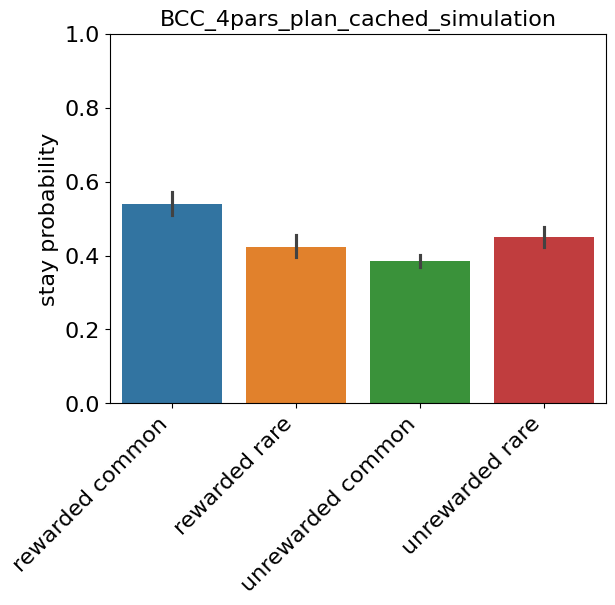

In [24]:
bar_names = ["rewarded common", "rewarded rare", "unrewarded common", "unrewarded rare"]

plt.figure()
g = sns.barplot(data=stayed_arr)
g.set_xticklabels(bar_names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=16)
plt.ylabel("stay probability", fontsize=16)
plt.title(fname_base[:-1], fontsize=16)
plt.savefig(os.path.join(base_dir,"simulated_stay_probs.svg"),dpi=300)
plt.show()

Check for correlations in the sampled true values. This is important if one finds correlations in the inferred values.

{'subject': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]]), 'dec temp': tensor([[3.1164, 5.5823, 4.1521, 4.3014, 5.7647, 4.4222, 5.2468, 2.7287, 5.4533,
         4.9568, 3.6035, 4.2738, 5.5458, 2.5805, 1.2093, 2.6207, 4.8356, 5.7307,
         2.2018, 4.7835, 2.1317, 5.3109, 5.3176, 4.3698, 2.0884, 1.7816, 2.0806,
         5.4432, 1.8042, 2.7792, 5.1391, 4.6302, 1.3632, 2.9614, 3.0586, 4.4837,
         1.7715, 3.7274, 1.3431, 1.2364, 4.2120, 2.8556, 3.5360, 3.9036, 4.0331,
         4.0008, 1.6874, 3.0179, 2.1541, 4.9789]]), 'reward rate': tensor([[1.8411e-01, 9.5917e-01, 8.2921e-01, 6.0935e-02, 8.9674e-01, 2.3236e-01,
         8.1989e-01, 6.3007e-01, 4.3389e-01, 4.0281e-01, 7.7381e-01, 9.5445e-01,
         5.0099e-01, 2.9181e-01, 6.8135e-01, 9.1254e-01, 8.8390e-01, 2.4878e-03,
         3.4580e-01, 5.0787e-01

<Figure size 640x480 with 0 Axes>

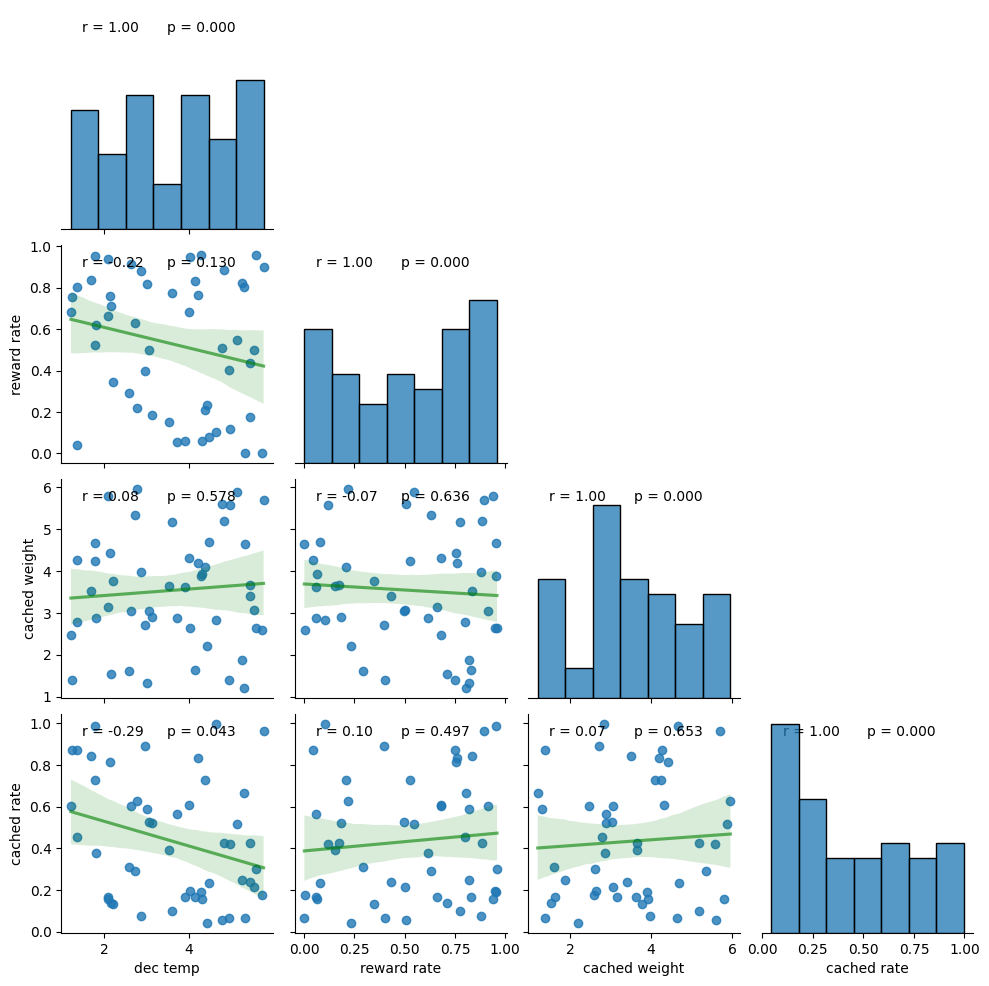

In [25]:
print(true_vals)
plot_true_correlations = True

if plot_true_correlations:

    print("Correlations between truw values")

    true_vals_df = pd.DataFrame()

    for name in param_names:
        trues = []
        for i in range(n_agents):
            trues.append(true_vals[name][true_vals['subject']==i])

        true_vals_df[name] = torch.tensor(trues)


    plt.figure()
    vars_of_interest = param_names
    f = sns.pairplot(data=true_vals_df, kind='reg', diag_kind="hist", corner=True,
                     plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                     x_vars=vars_of_interest, y_vars=vars_of_interest)
    f.map(tu.annot_corrfunc)
    plt.savefig(os.path.join(base_dir, fname_base+"_pairplot_true_vals_corr.svg"))
    plt.show()

#### Inference

Inference pre-setup

In [26]:
# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_recovery_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(recovery_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(recovery_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 600

BCC_4pars_plan_cached_recovery_


<b>Decide</b> for running or loading inference

In [27]:
run_inference = True

<b>Either:</b> Set up agent and inference. Run main inference loop, plot intermediate and end results

4
analyzing 50 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 100 out of total 600


Mean ELBO 12666.90: 100%|██████████| 100/100 [20:41<00:00, 12.42s/it]


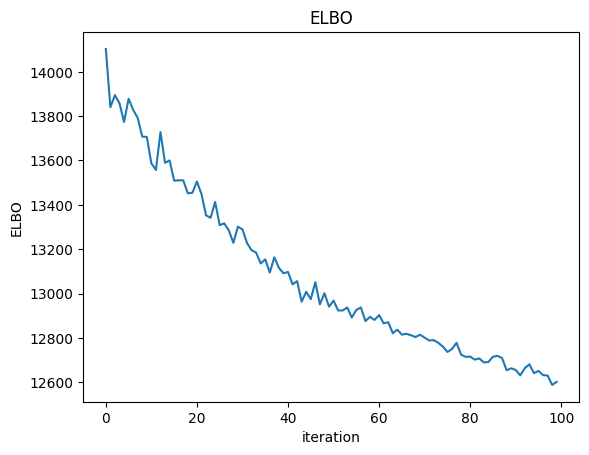

       reward rate  dec temp  cached weight  cached rate  subject
0         0.563166  1.733249       1.825665     0.414381        0
1         0.685339  3.748308       3.729125     0.391803        1
2         0.711183  4.259484       0.965343     0.189263        2
3         0.188347  6.069031       4.383971     0.240998        3
4         0.667221  4.222578       4.385115     0.581046        4
...            ...       ...            ...          ...      ...
24995     0.504035  4.677477       3.876572     0.485642       45
24996     0.899547  8.298937       3.995212     0.707707       46
24997     0.239085  1.070331       1.713641     0.393387       47
24998     0.781372  6.390730       3.607601     0.441168       48
24999     0.226359  5.529478       6.038024     0.604155       49

[25000 rows x 5 columns]


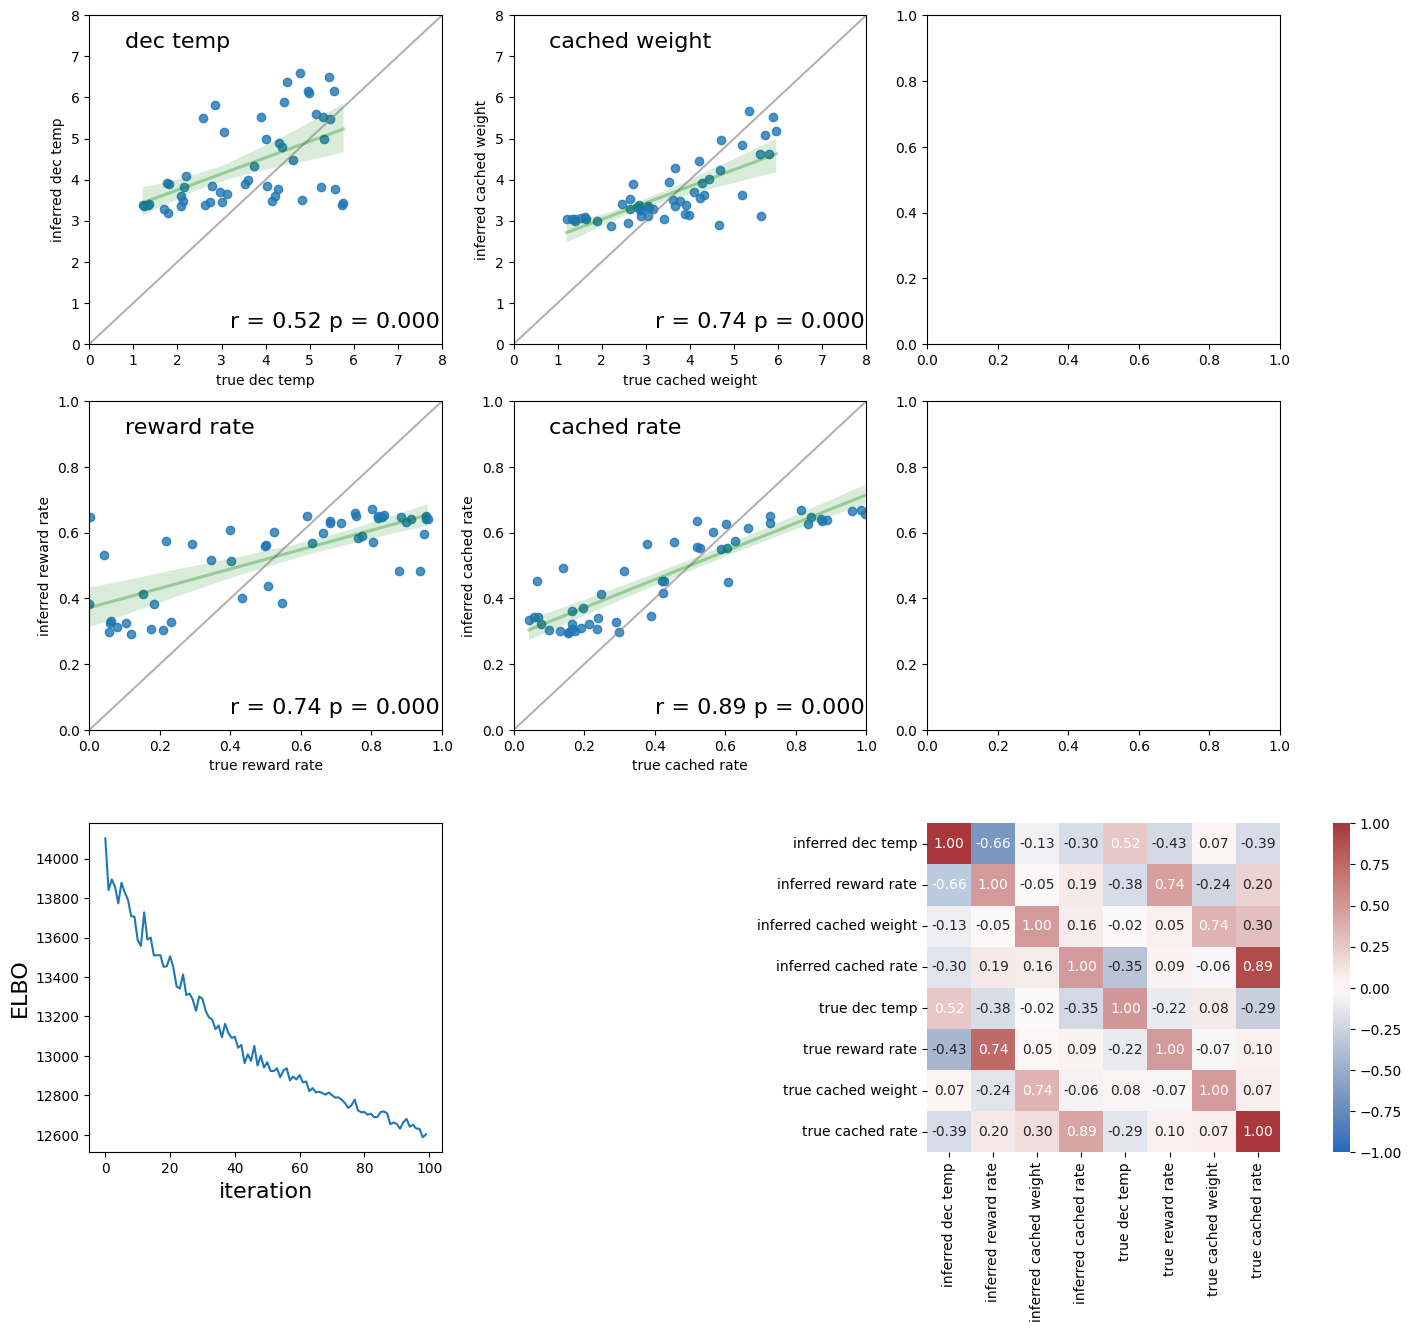

<Figure size 640x480 with 0 Axes>

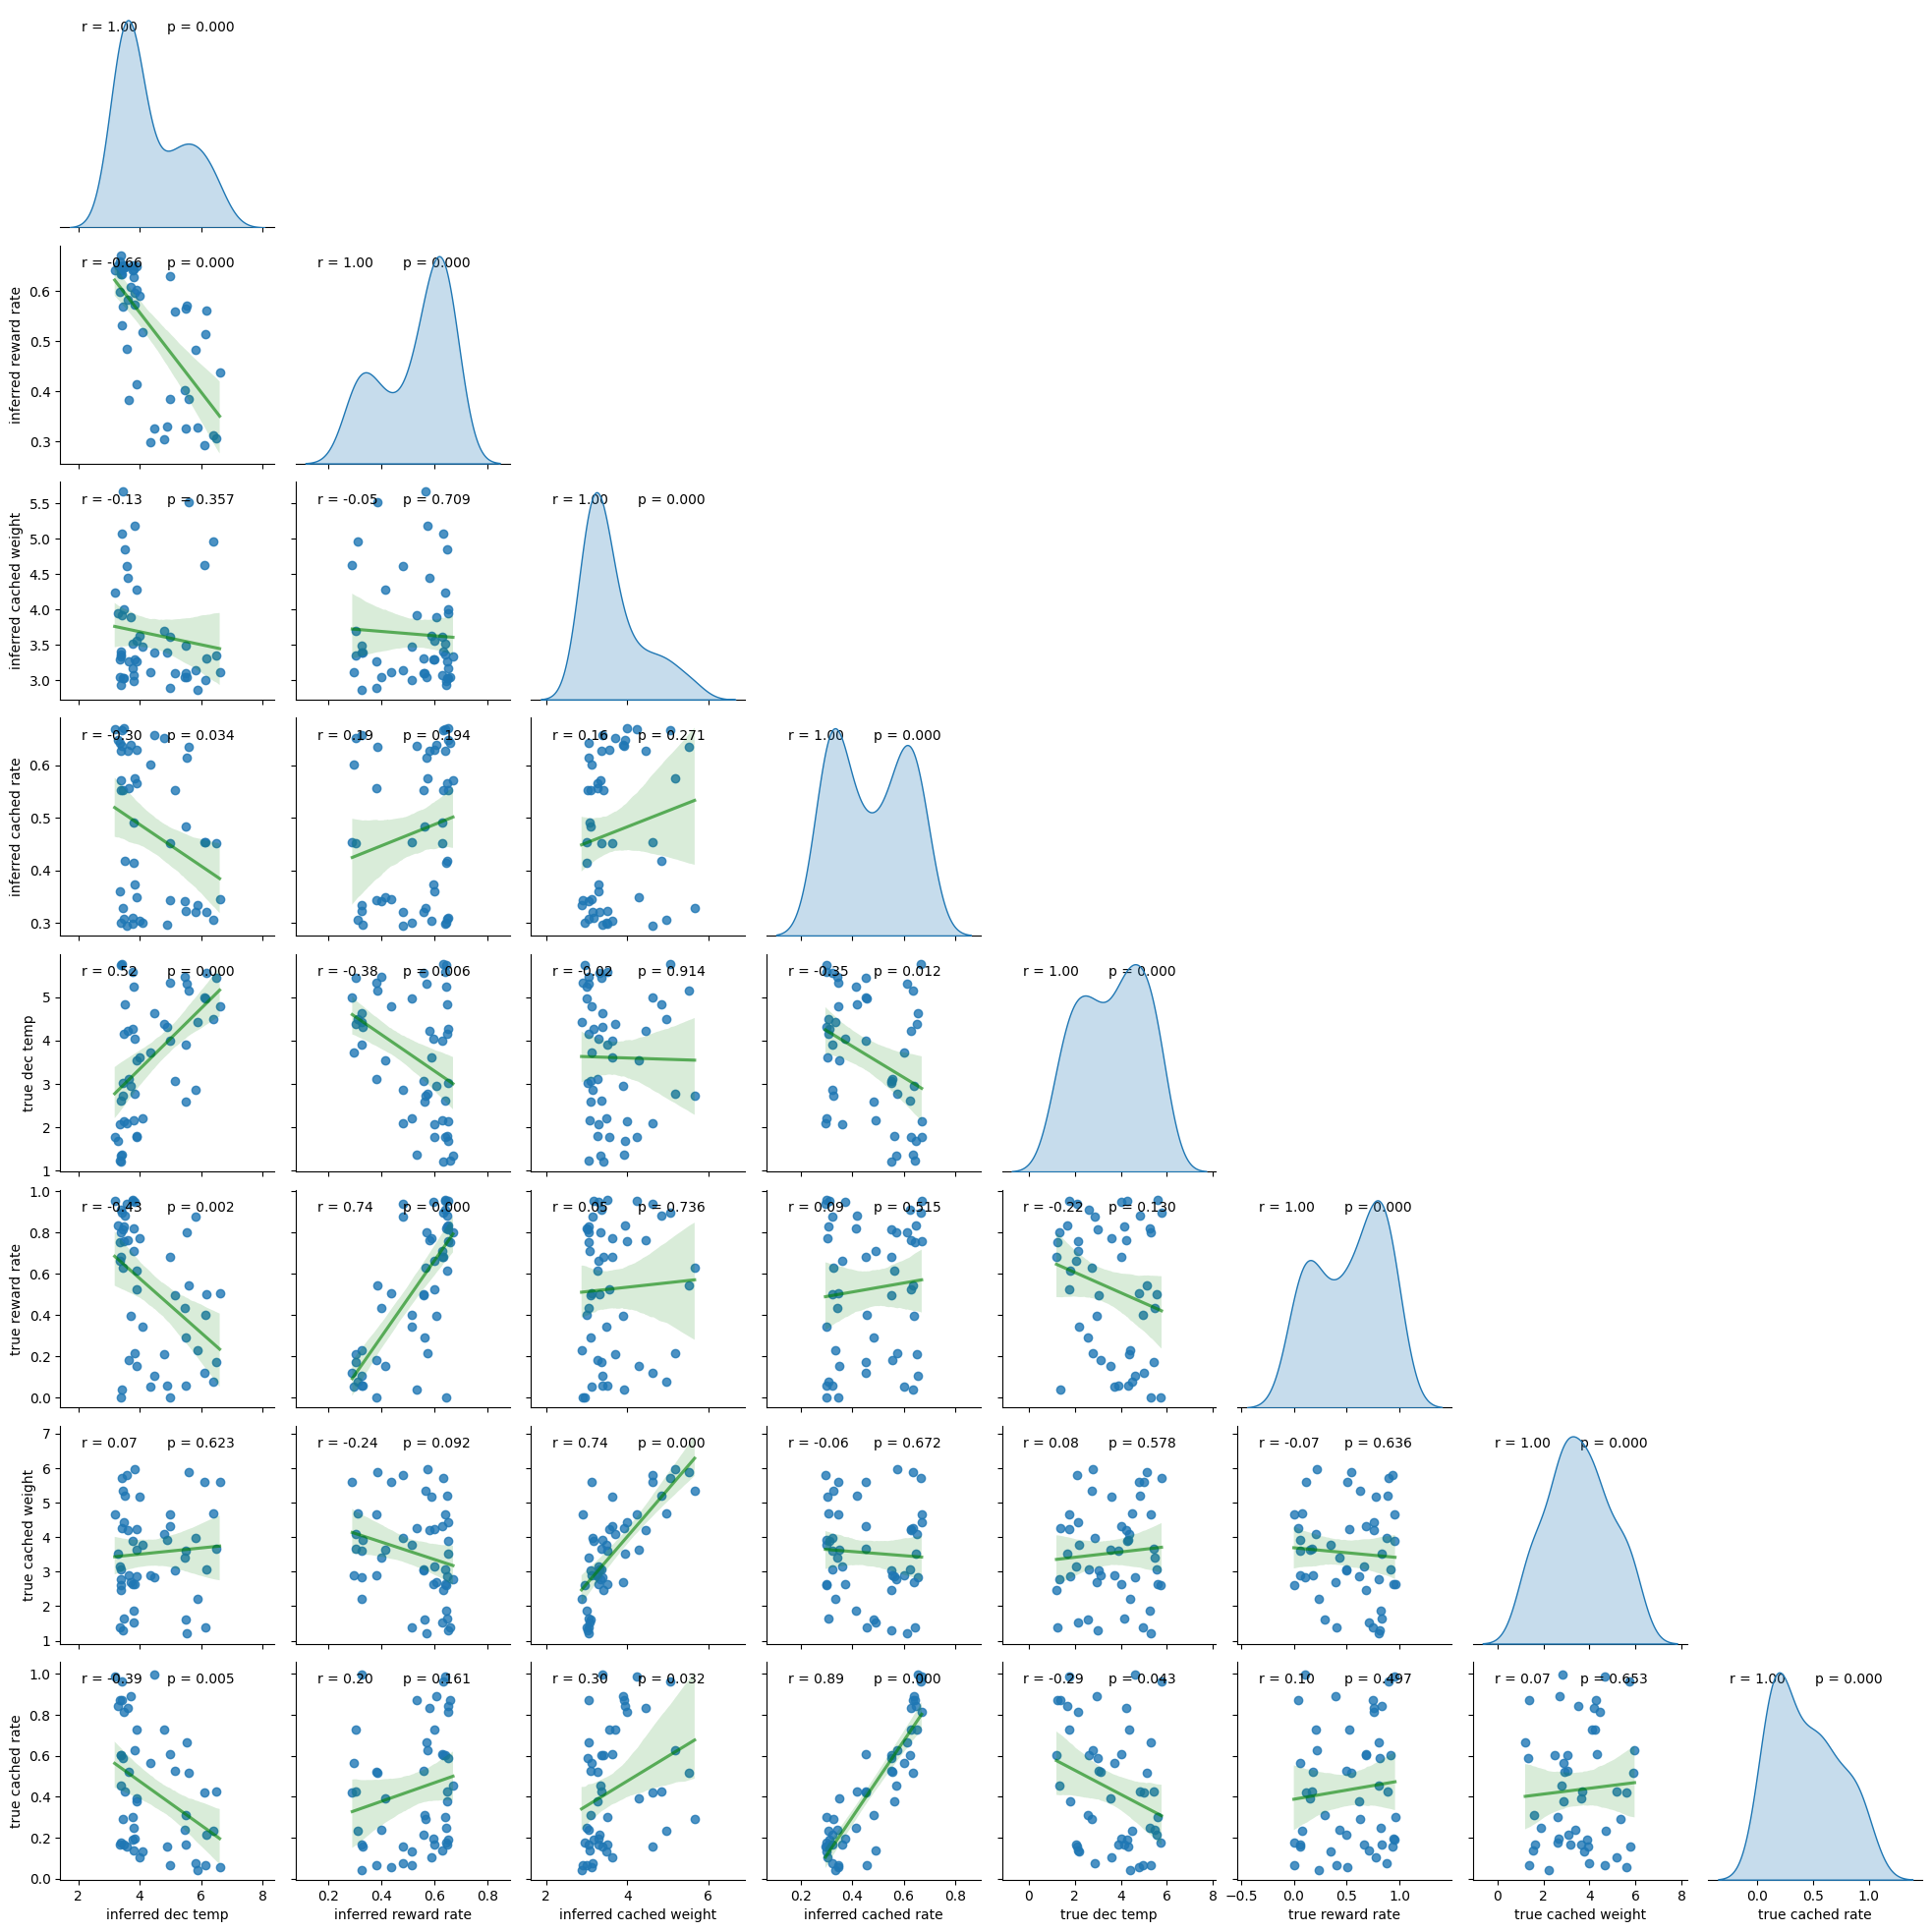

<Figure size 640x480 with 0 Axes>

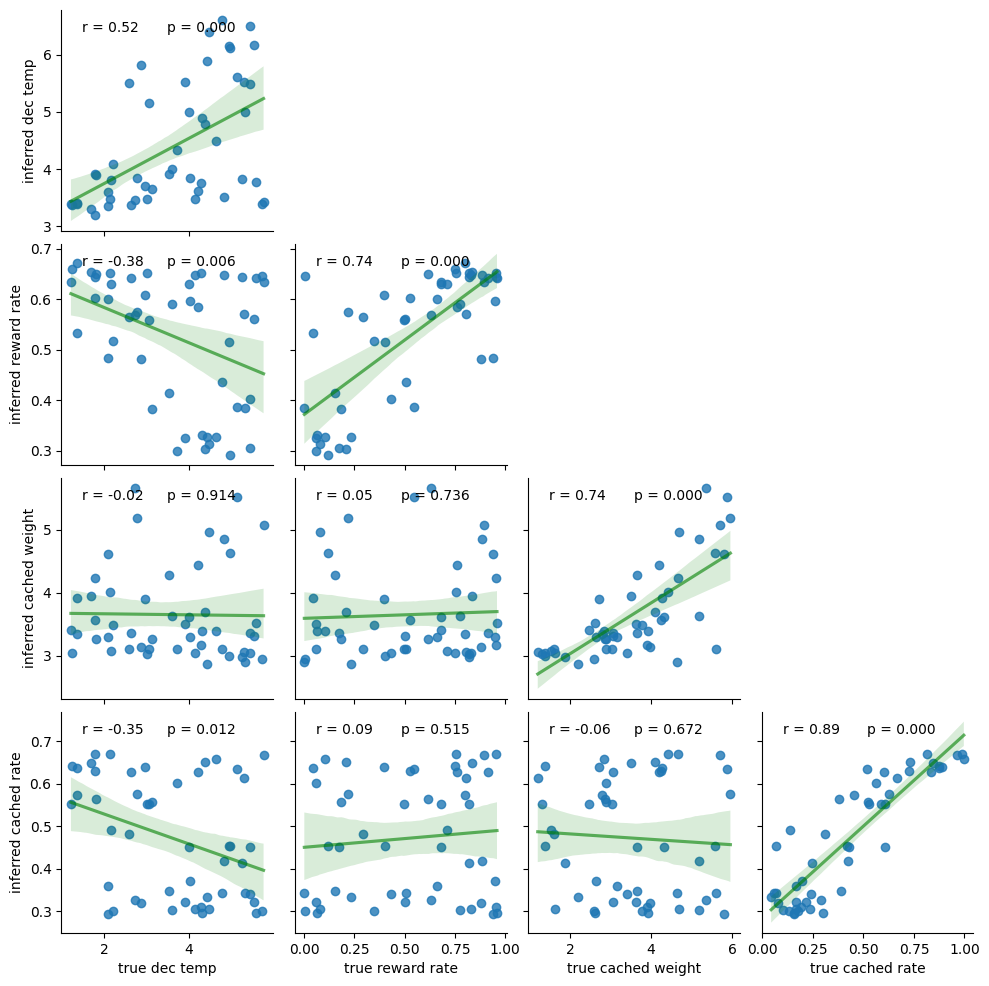

<Figure size 640x480 with 0 Axes>

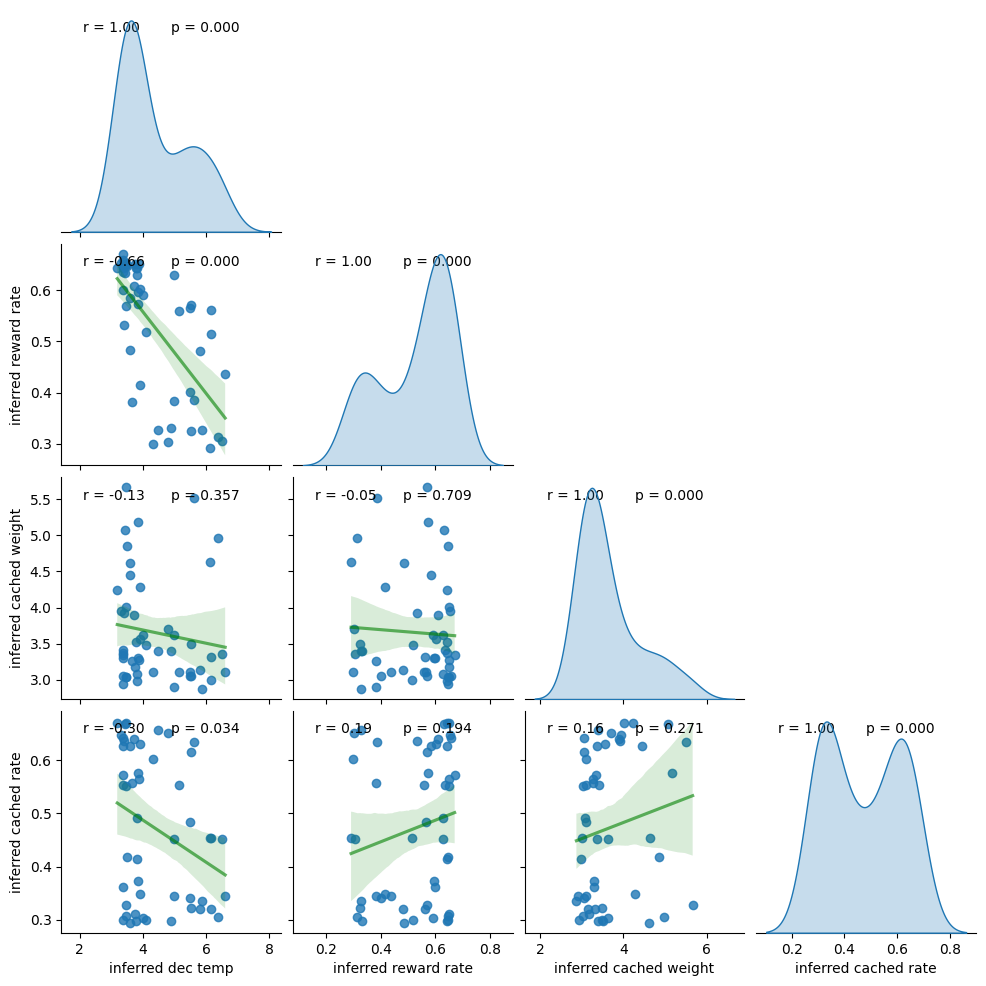

taking steps 101 to 200 out of total 600


Mean ELBO 12355.83: 100%|██████████| 100/100 [23:47<00:00, 14.28s/it]


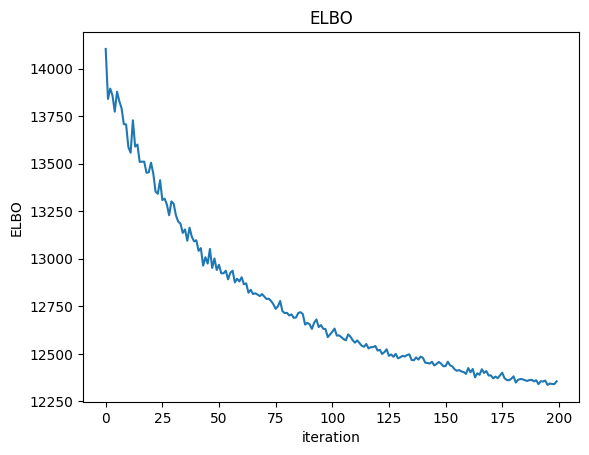

       reward rate  dec temp  cached weight  cached rate  subject
0         0.270239  2.035642       3.686499     0.576127        0
1         0.863191  5.163613       3.266171     0.115824        1
2         0.780204  3.658298       2.579896     0.187884        2
3         0.092800  4.255166       3.389538     0.157673        3
4         0.479853  3.097108       3.796271     0.807476        4
...            ...       ...            ...          ...      ...
24995     0.726012  4.439419       3.430230     0.324800       45
24996     0.629933  2.352101       2.319136     0.843858       46
24997     0.397369  1.494877       2.826009     0.319410       47
24998     0.668299  4.870894       1.414958     0.431352       48
24999     0.095238  4.883015       5.656804     0.467731       49

[25000 rows x 5 columns]


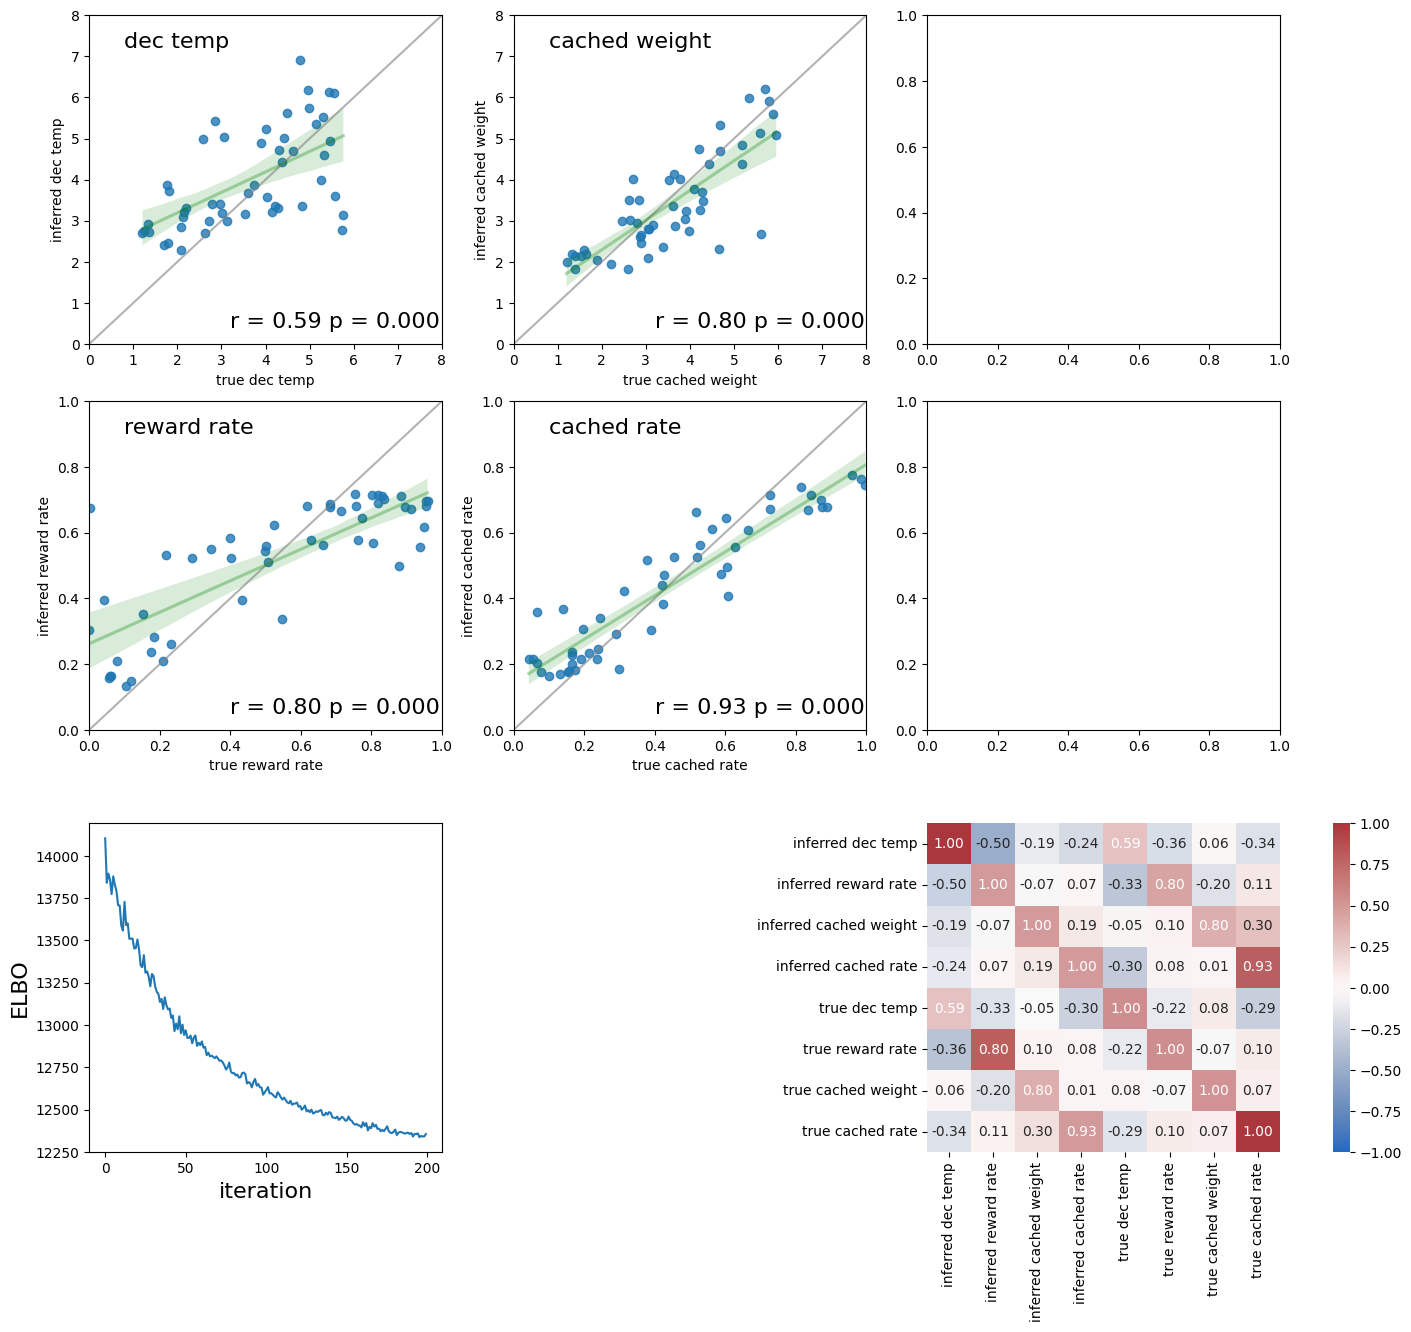

<Figure size 640x480 with 0 Axes>

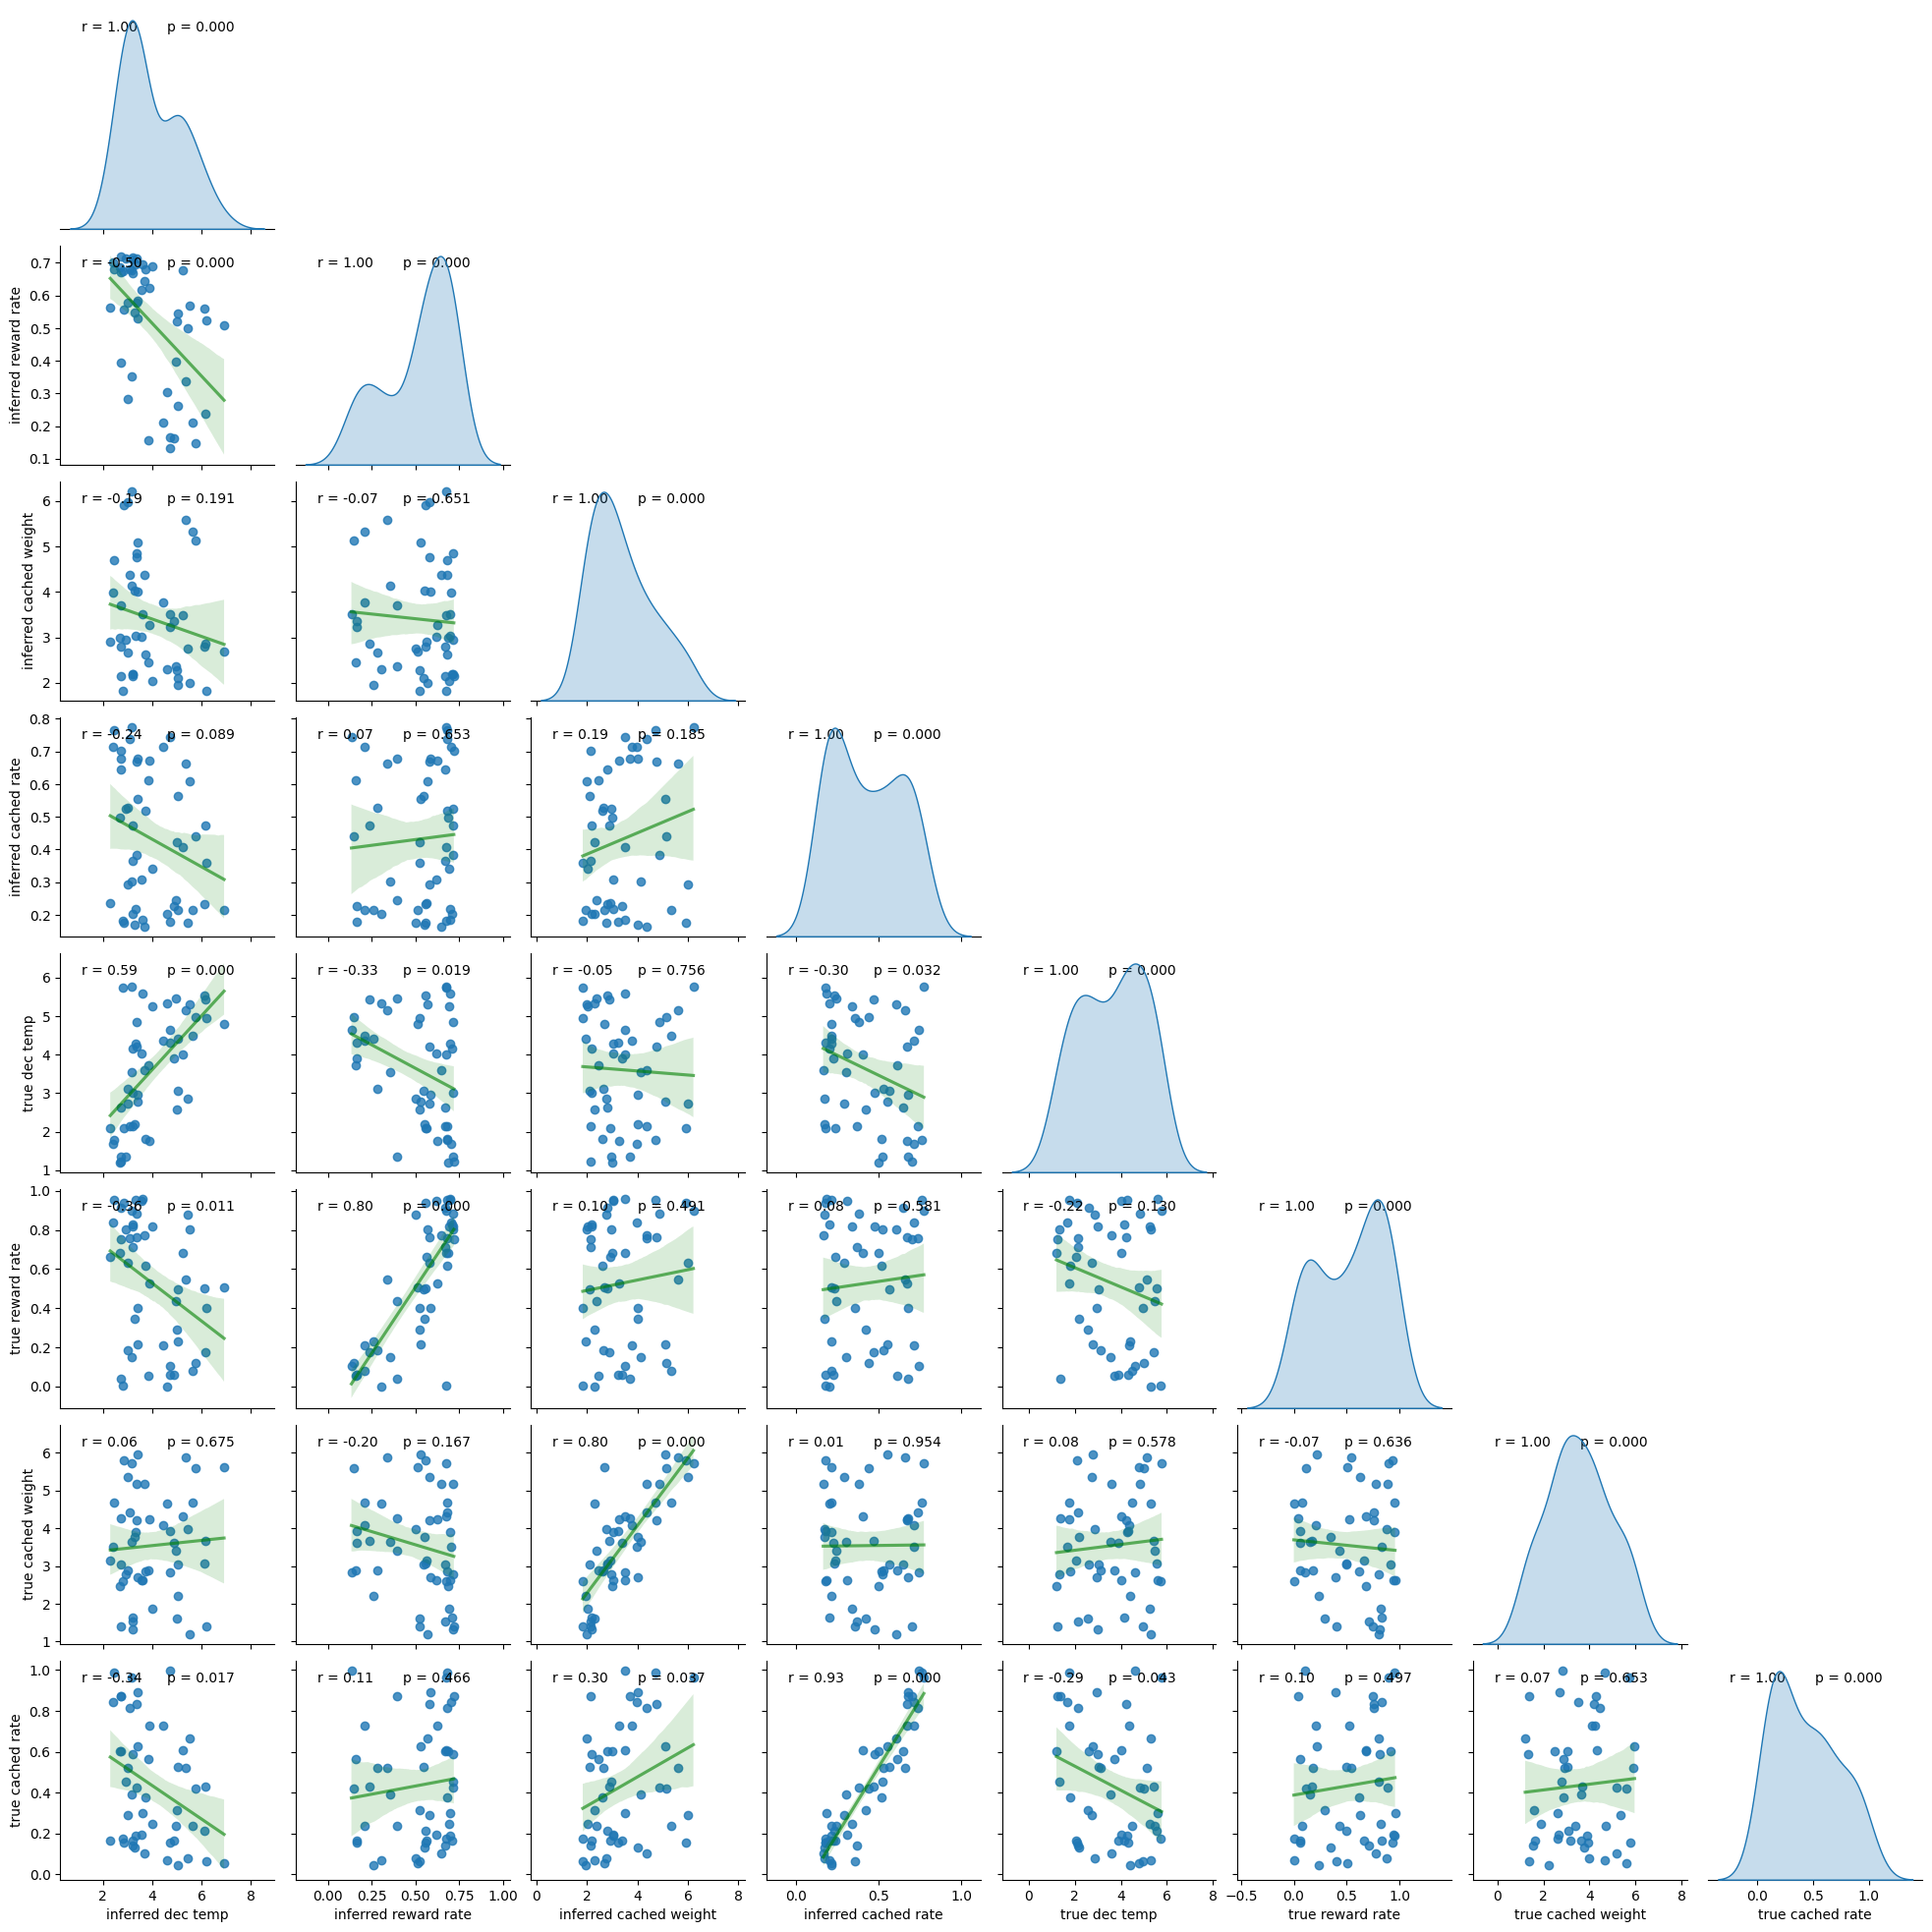

<Figure size 640x480 with 0 Axes>

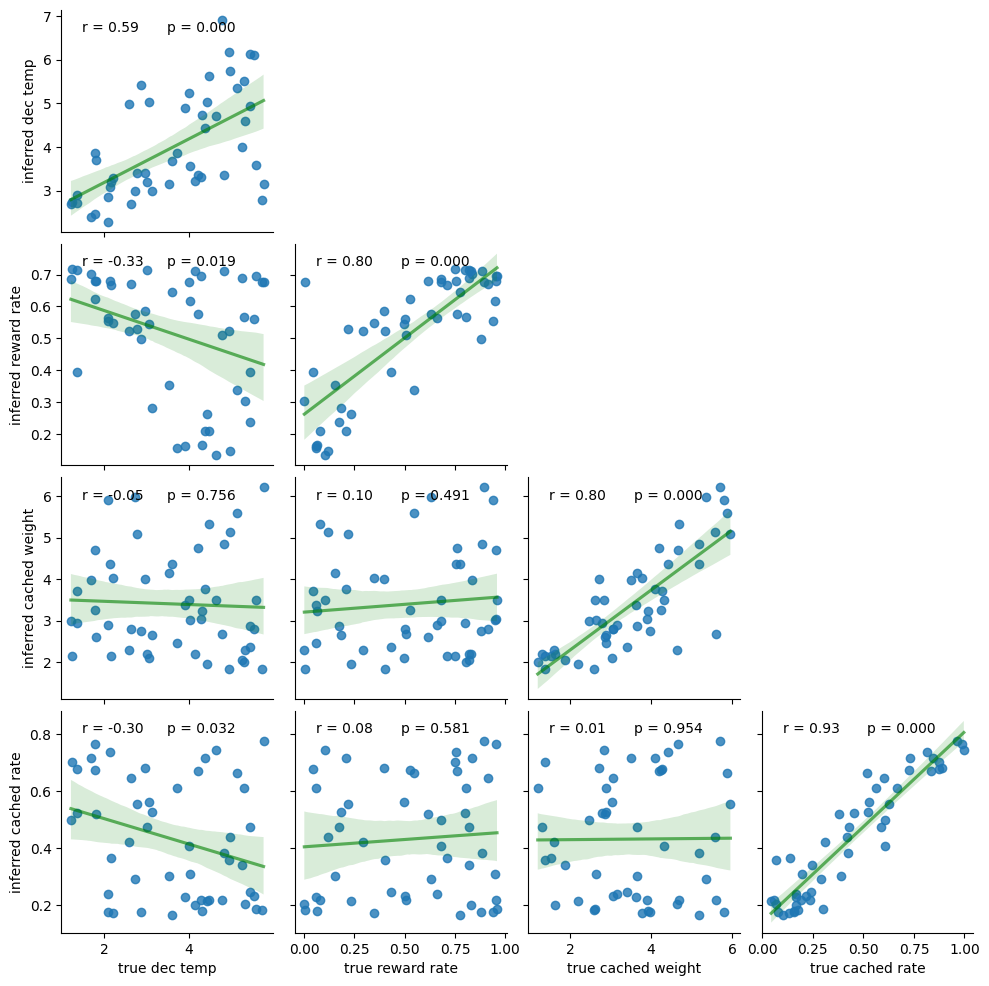

<Figure size 640x480 with 0 Axes>

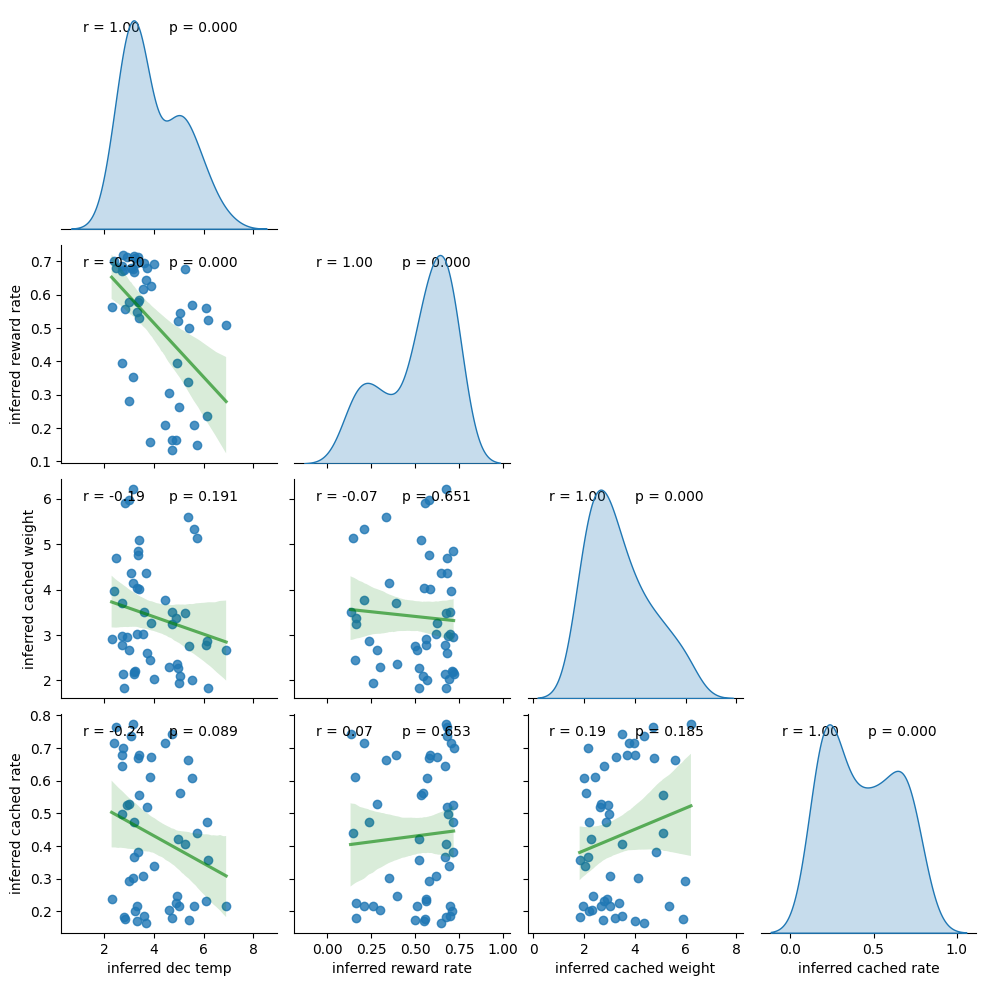

taking steps 201 to 300 out of total 600


Mean ELBO 12256.26: 100%|██████████| 100/100 [25:39<00:00, 15.40s/it]


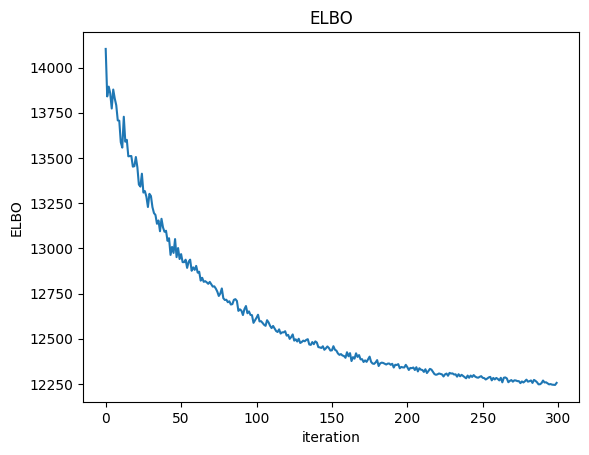

       reward rate  dec temp  cached weight  cached rate  subject
0         0.266037  3.411669       2.759718     0.584527        0
1         0.903527  2.830436       2.805295     0.163454        1
2         0.666280  3.310194       1.478423     0.315699        2
3         0.048747  4.737128       6.002464     0.216400        3
4         0.774635  1.448376       5.716288     0.814670        4
...            ...       ...            ...          ...      ...
24995     0.763894  4.814618       4.183465     0.421711       45
24996     0.403441  2.434000       3.962152     0.791383       46
24997     0.521371  1.181093       0.978624     0.390946       47
24998     0.745719  1.820131       3.349764     0.196804       48
24999     0.067441  4.383149       5.002706     0.305825       49

[25000 rows x 5 columns]


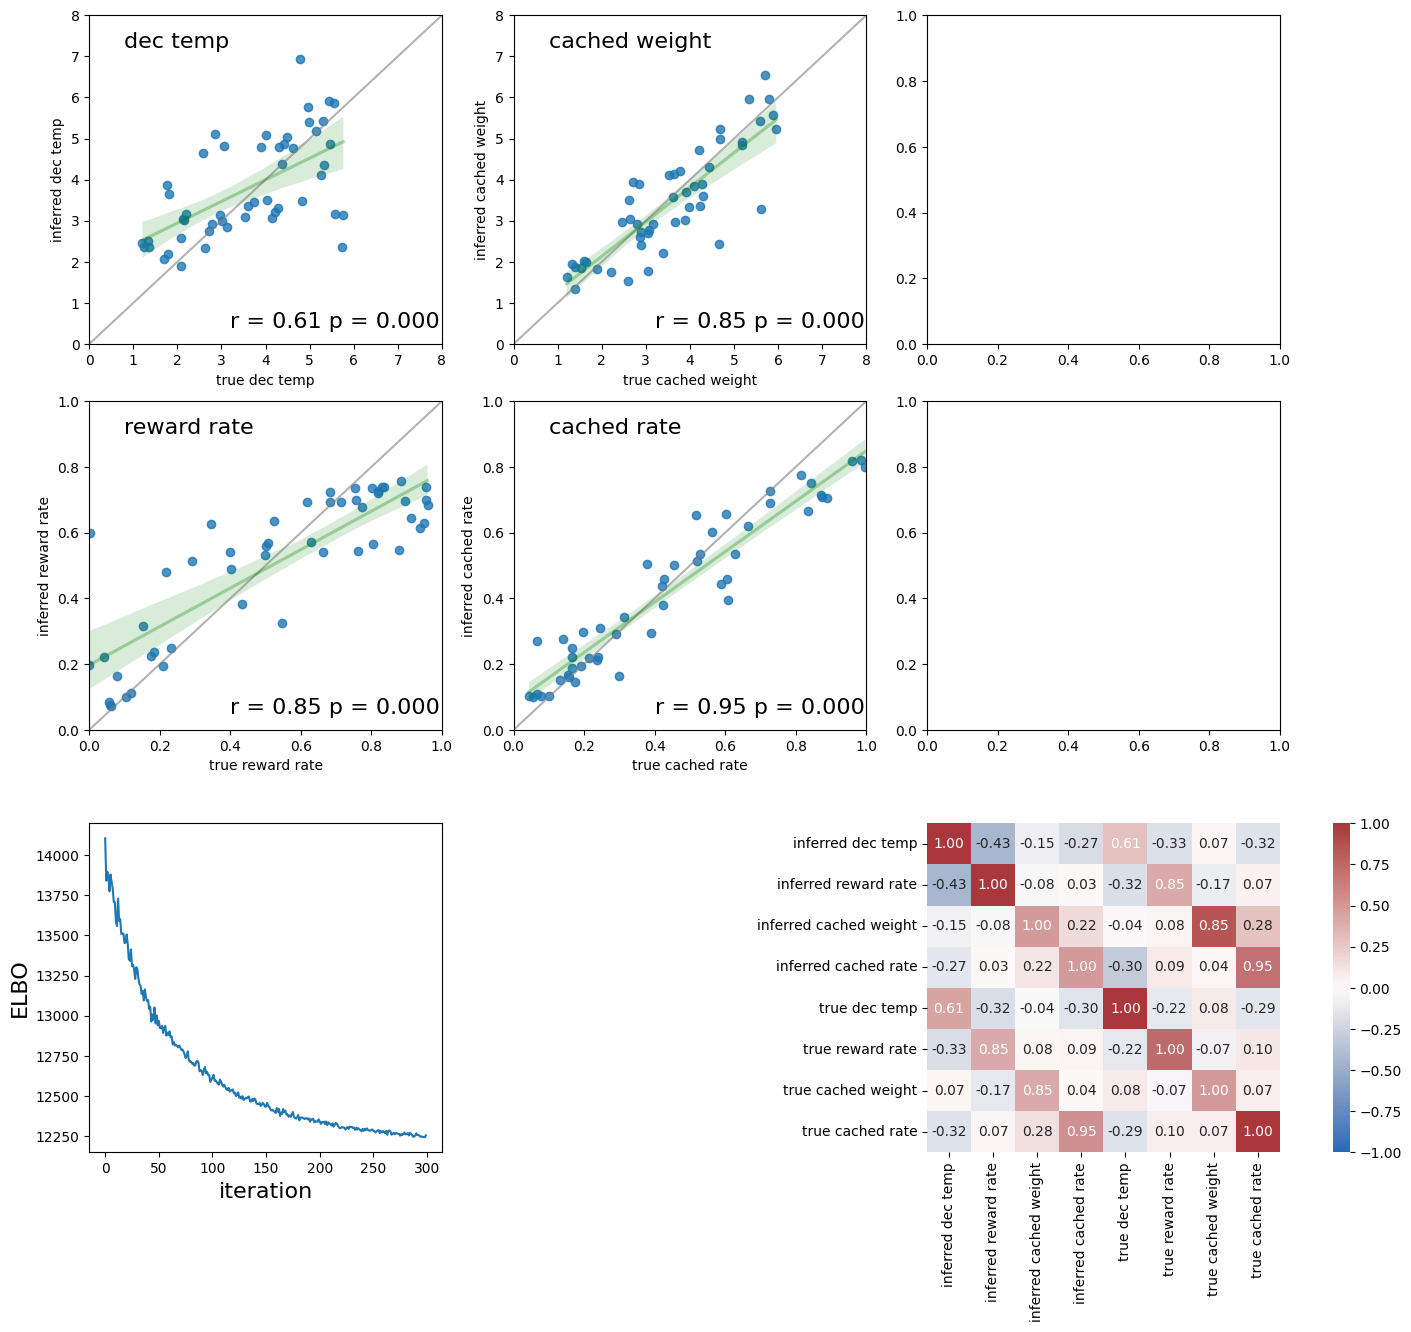

<Figure size 640x480 with 0 Axes>

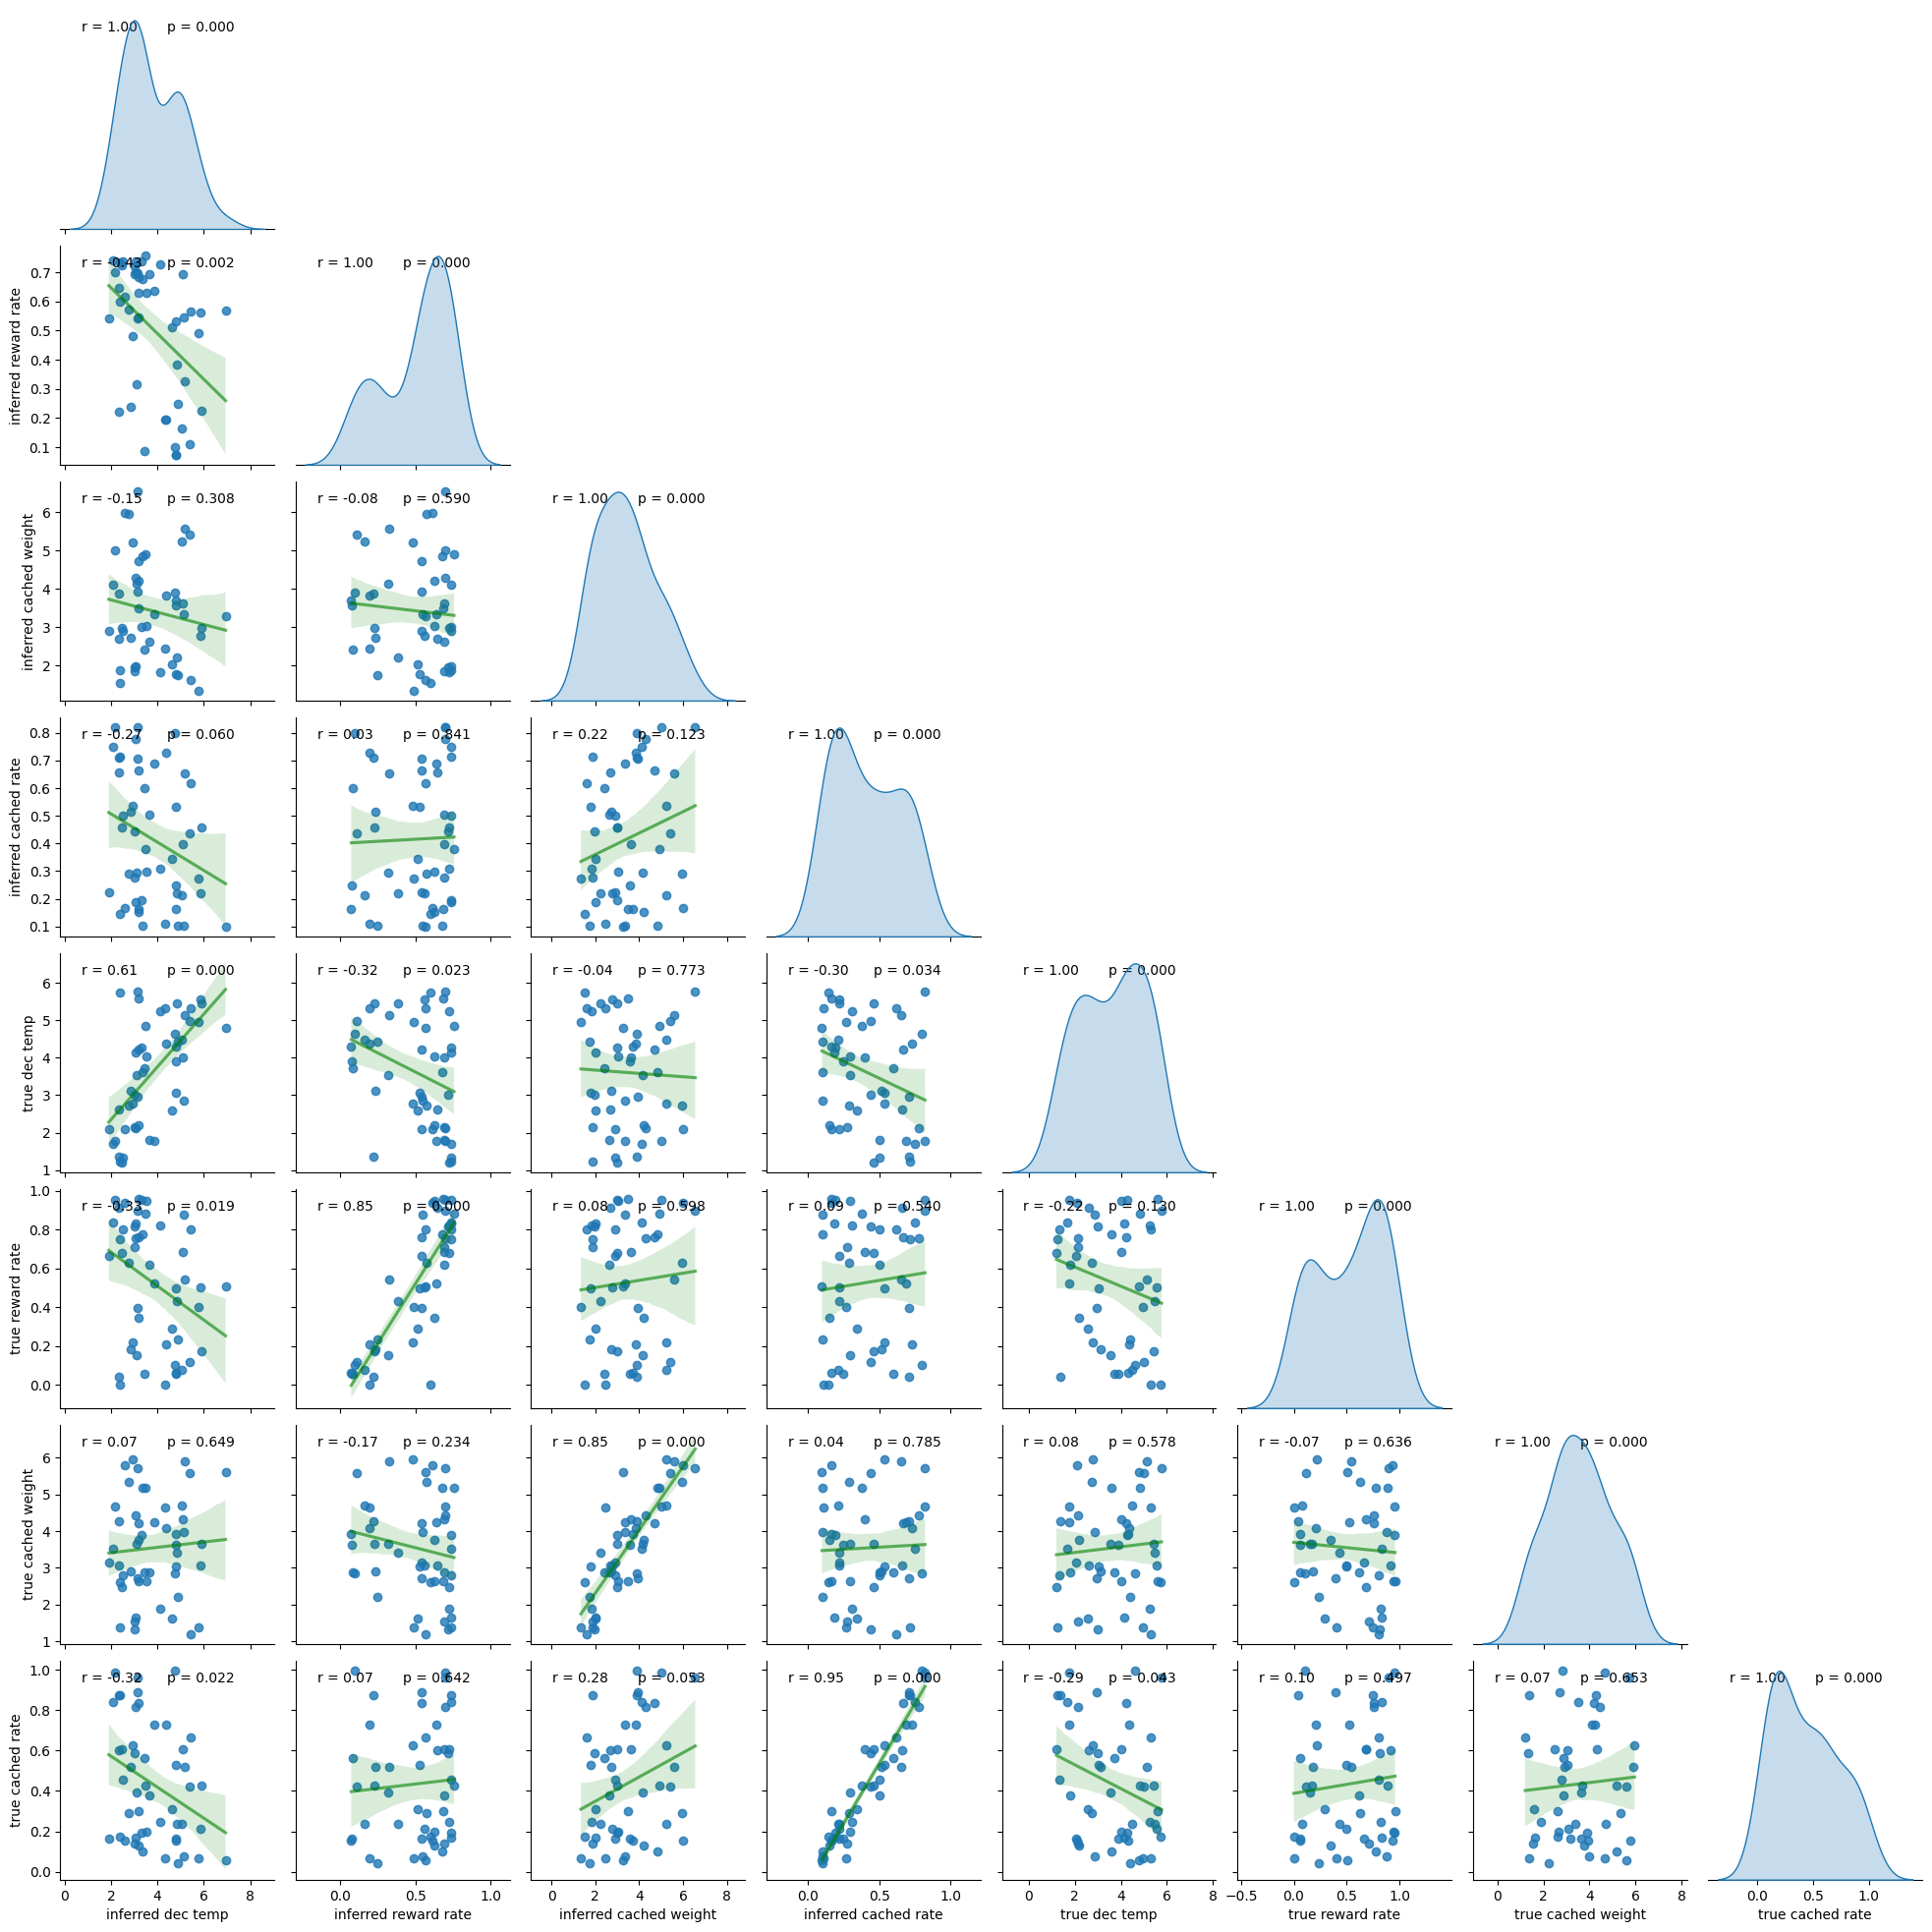

<Figure size 640x480 with 0 Axes>

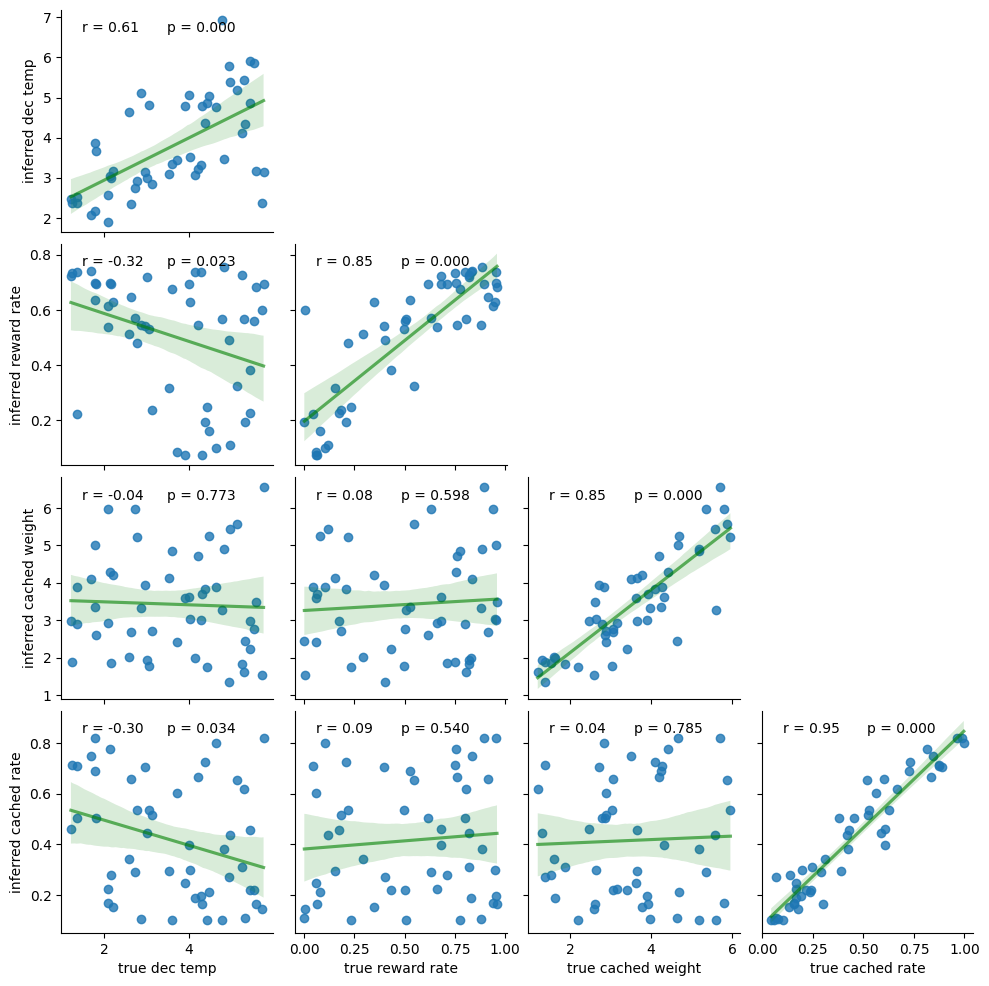

<Figure size 640x480 with 0 Axes>

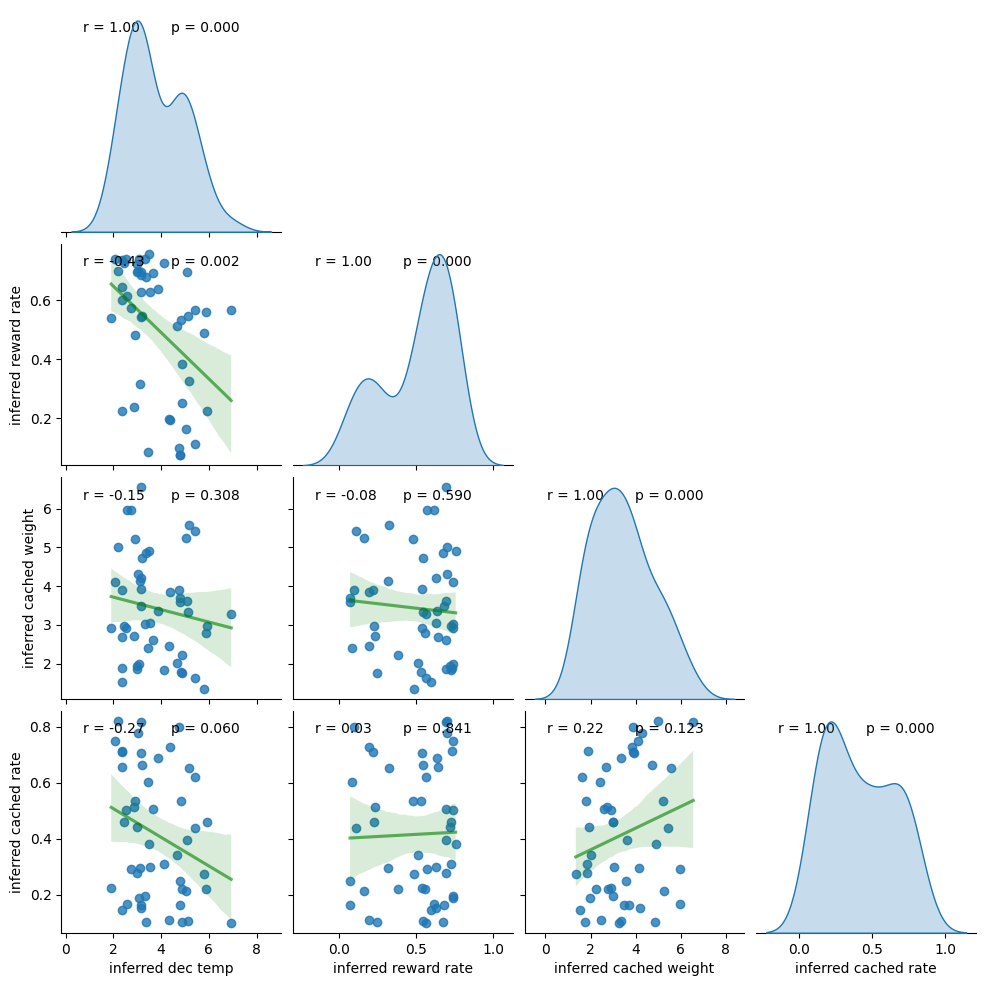

taking steps 301 to 400 out of total 600


Mean ELBO 12203.95: 100%|██████████| 100/100 [26:05<00:00, 15.66s/it]


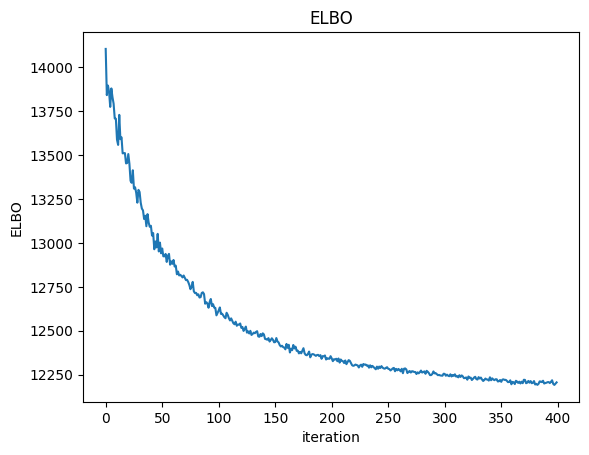

       reward rate  dec temp  cached weight  cached rate  subject
0         0.207548  3.642260       1.824790     0.582149        0
1         0.880183  4.489711       4.136194     0.223274        1
2         0.826693  1.981892       3.268421     0.113415        2
3         0.058448  4.700012       4.458430     0.149574        3
4         0.462876  1.230465       6.036176     0.859297        4
...            ...       ...            ...          ...      ...
24995     0.889516  5.049091       3.437457     0.415993       45
24996     0.738491  0.834379       3.226748     0.870084       46
24997     0.949503  5.698027       2.019545     0.379948       47
24998     0.920921  6.292156       1.895073     0.198825       48
24999     0.076045  5.652947       5.351891     0.459055       49

[25000 rows x 5 columns]


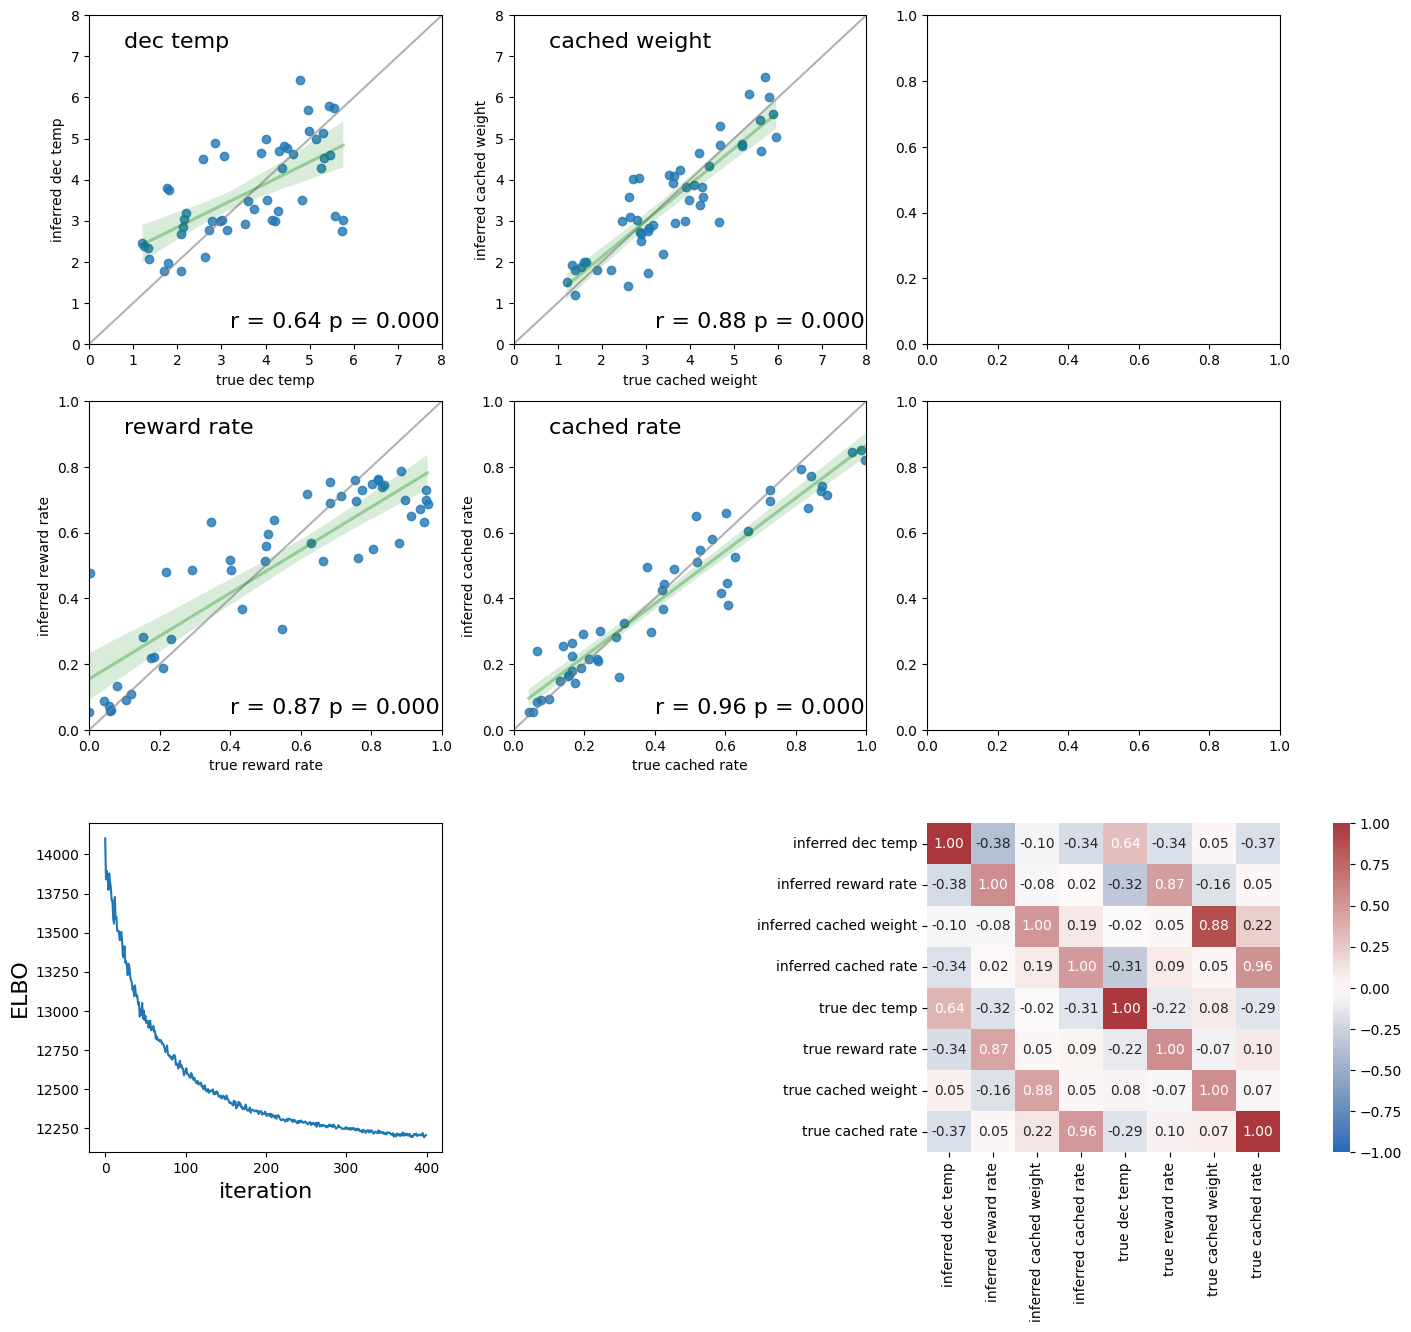

<Figure size 640x480 with 0 Axes>

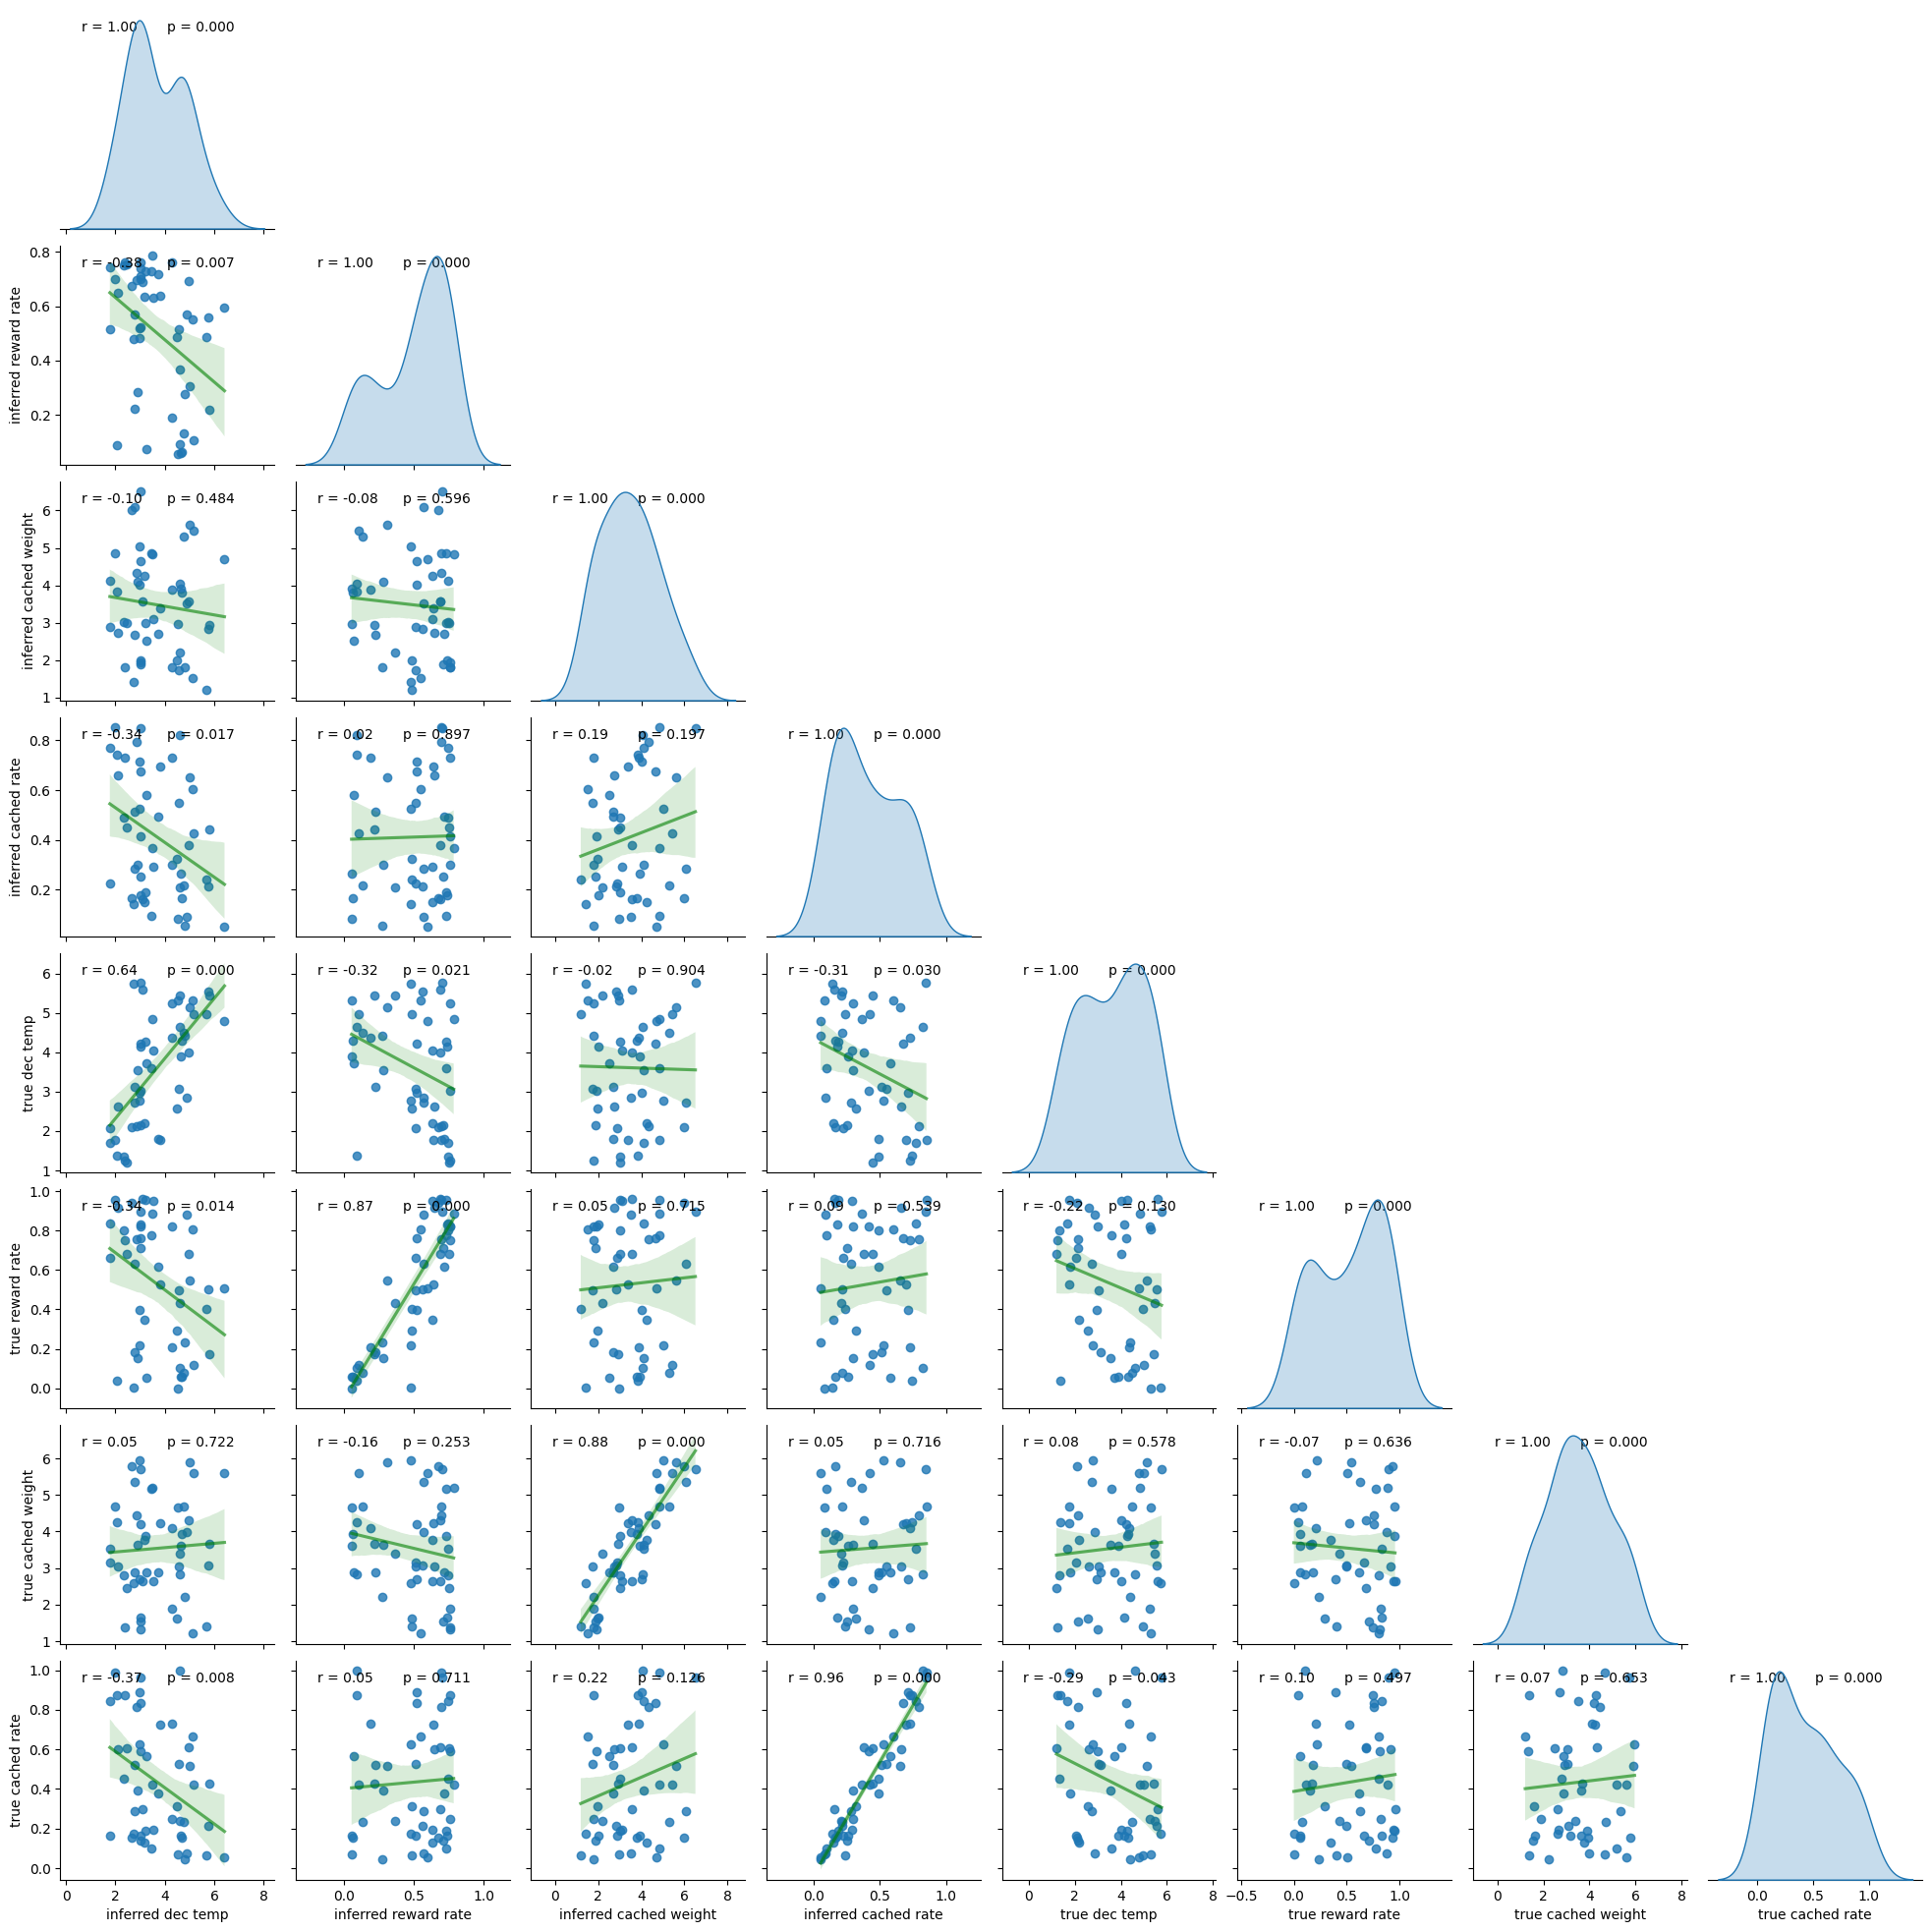

<Figure size 640x480 with 0 Axes>

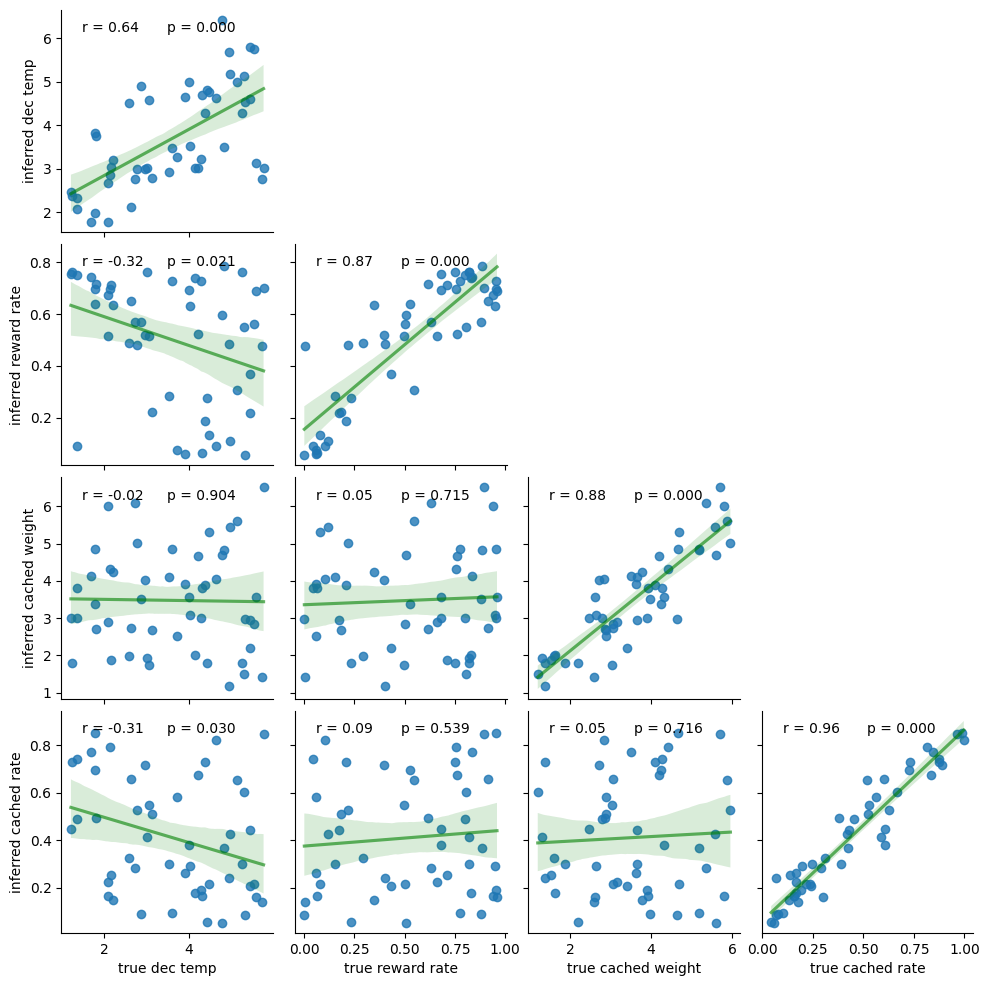

<Figure size 640x480 with 0 Axes>

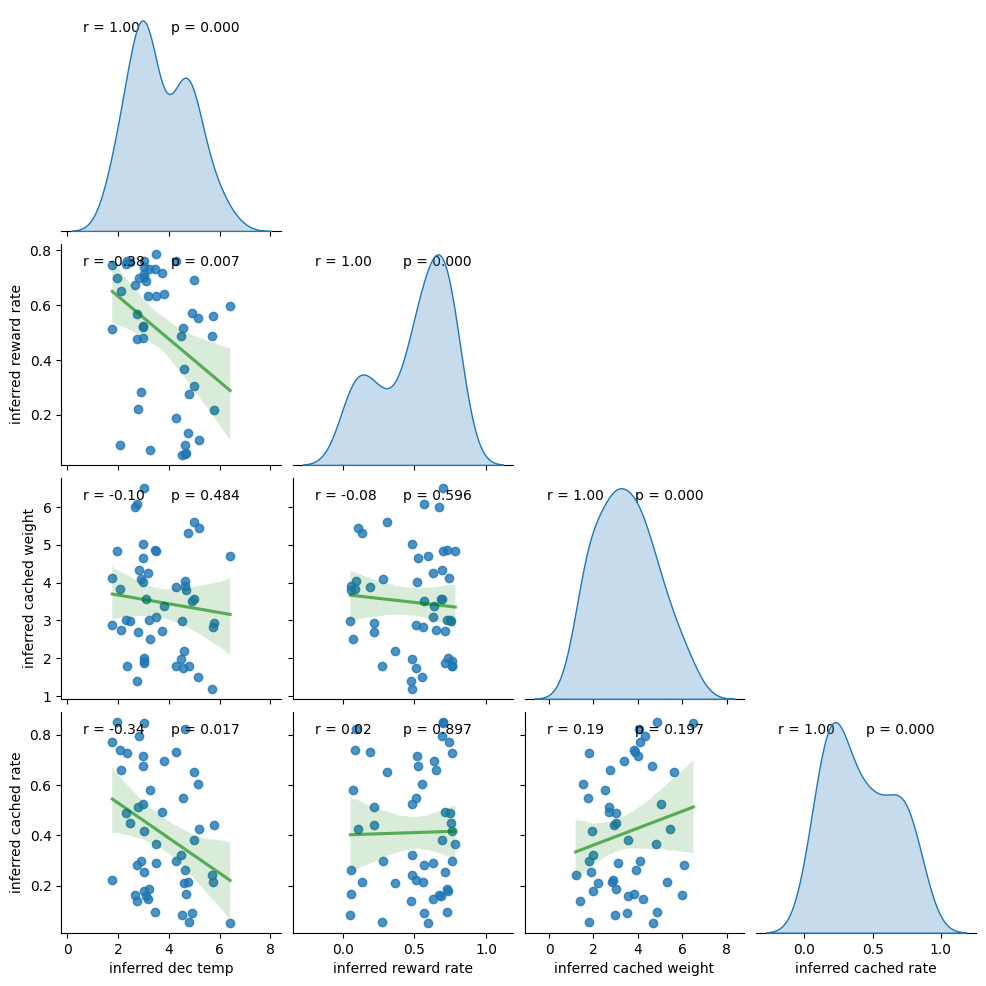

taking steps 401 to 500 out of total 600


Mean ELBO 12165.32: 100%|██████████| 100/100 [25:03<00:00, 15.04s/it]


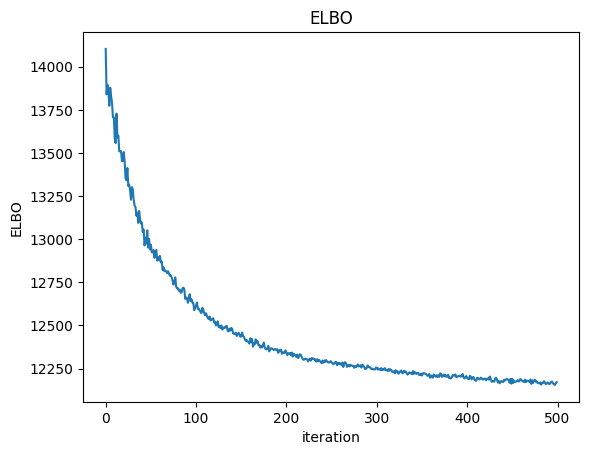

       reward rate  dec temp  cached weight  cached rate  subject
0         0.284571  2.821891       1.771059     0.469891        0
1         0.871367  2.615807       2.783154     0.211588        1
2         0.798858  1.551035       2.482773     0.154103        2
3         0.062175  6.100787       4.486761     0.166610        3
4         0.814193  3.214411       6.356045     0.849674        4
...            ...       ...            ...          ...      ...
24995     0.712673  3.749263       2.842211     0.337437       45
24996     0.930026  5.299291       4.391677     0.763340       46
24997     0.736183  1.499559       1.463575     0.301503       47
24998     0.861160  3.479116       2.395834     0.203320       48
24999     0.105889  5.152611       2.918742     0.406203       49

[25000 rows x 5 columns]


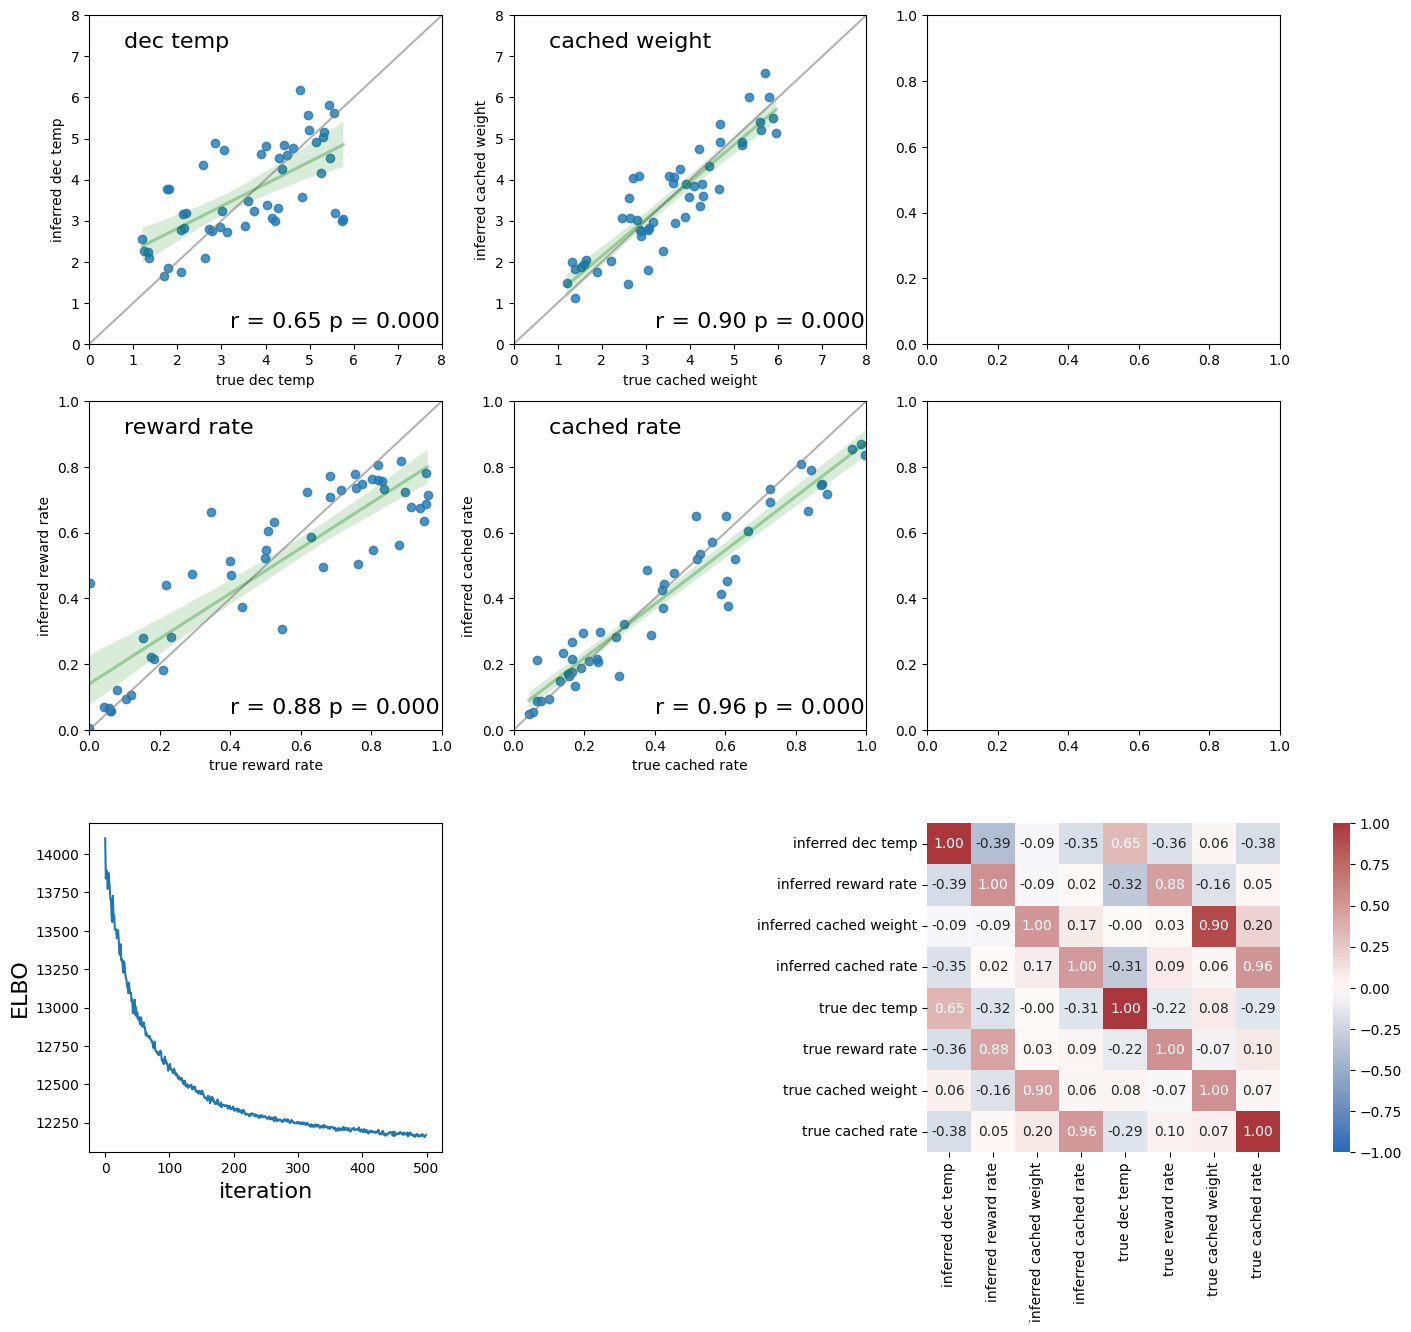

<Figure size 640x480 with 0 Axes>

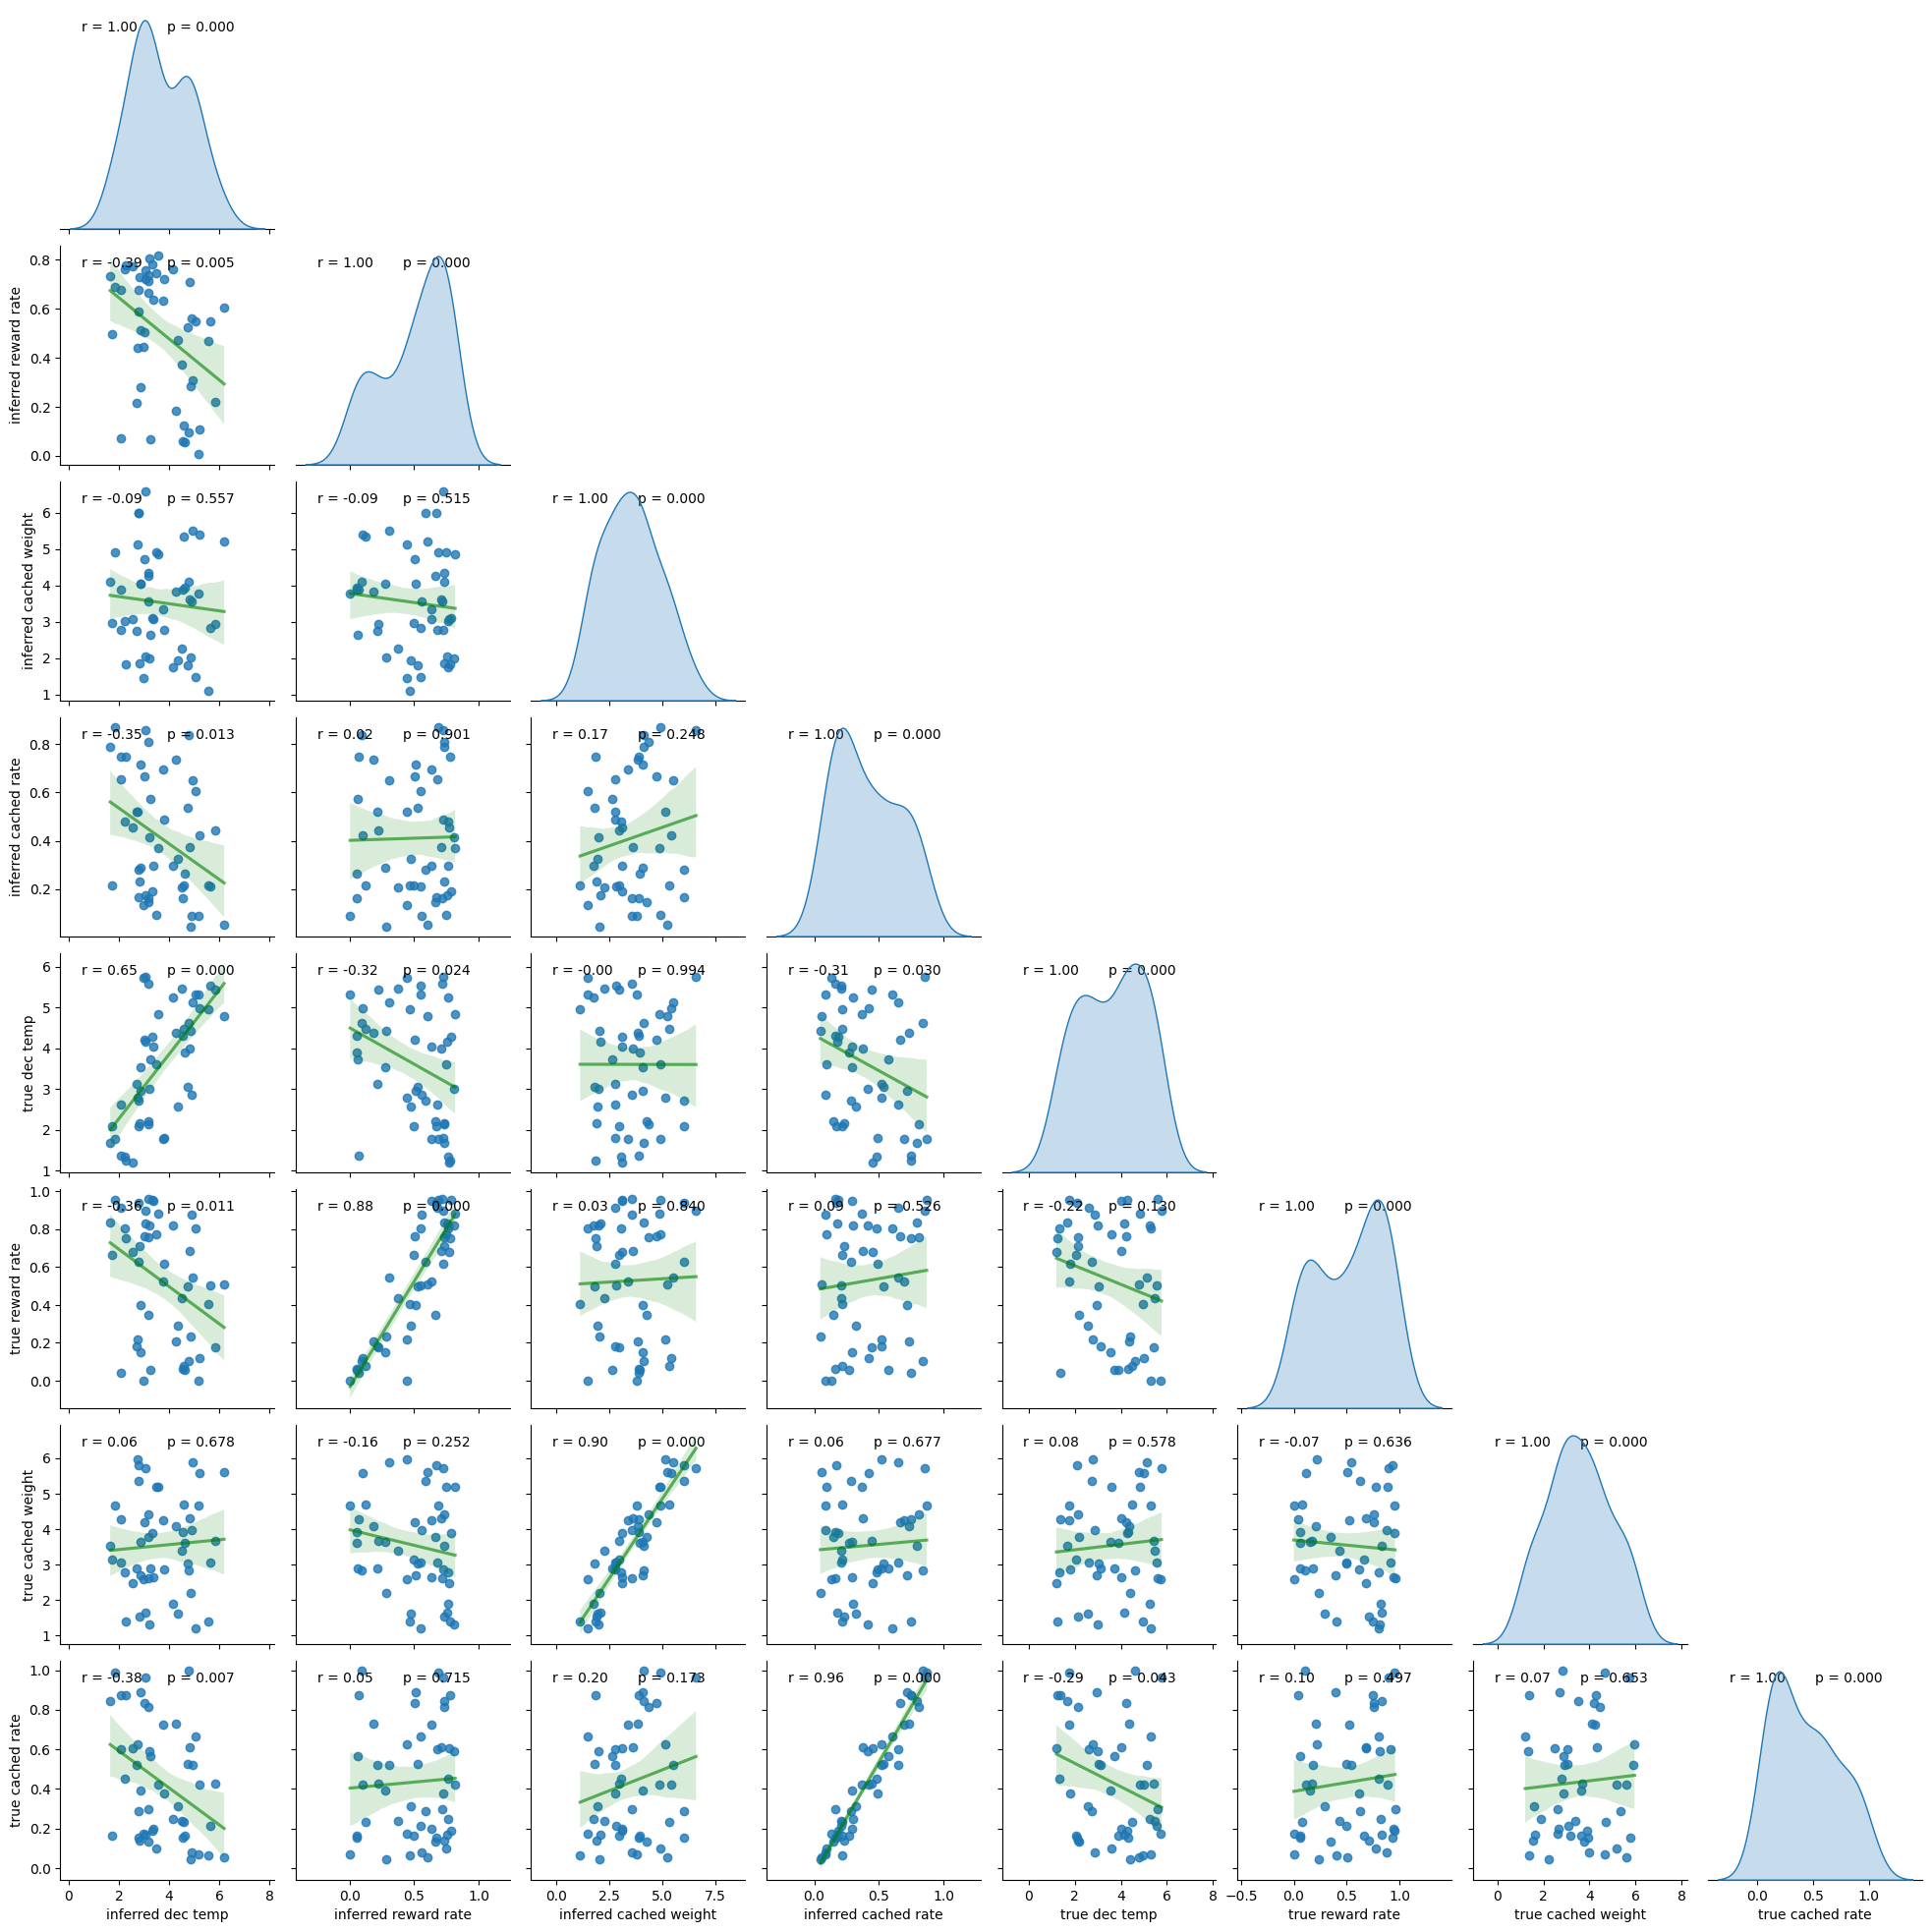

<Figure size 640x480 with 0 Axes>

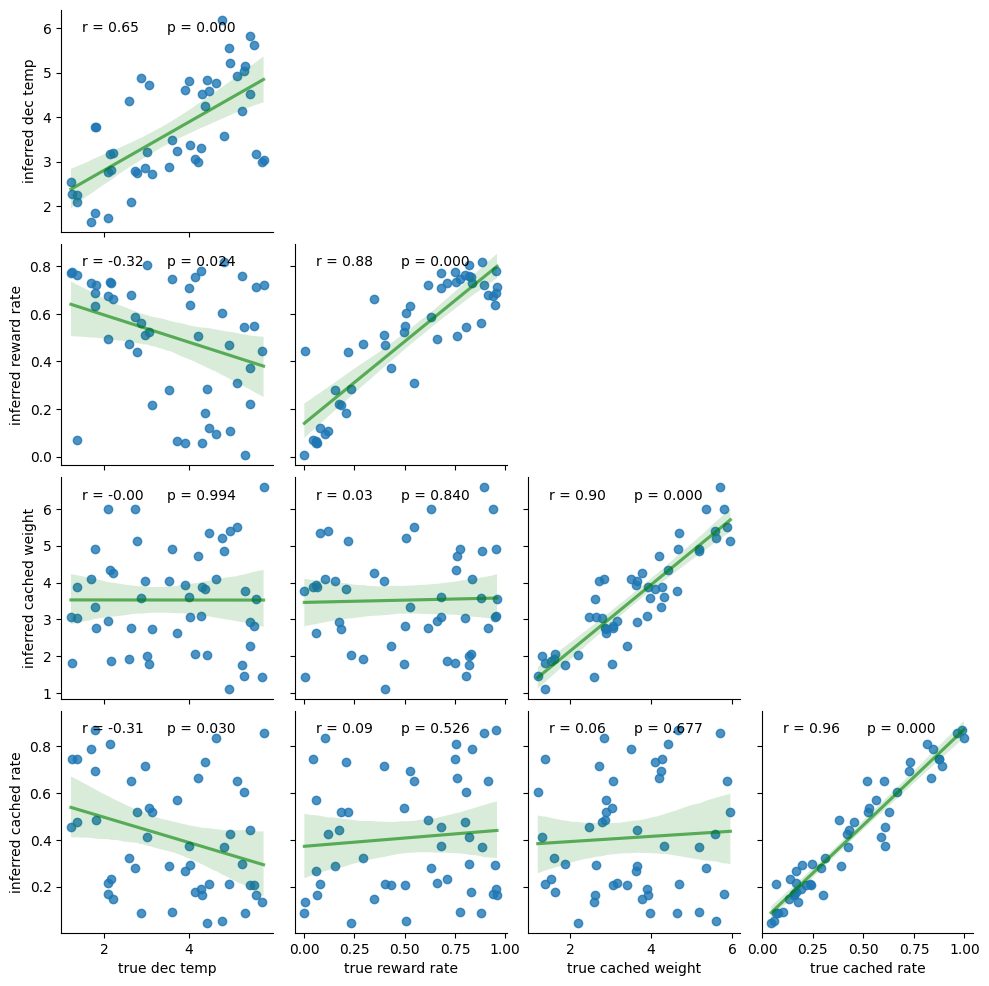

<Figure size 640x480 with 0 Axes>

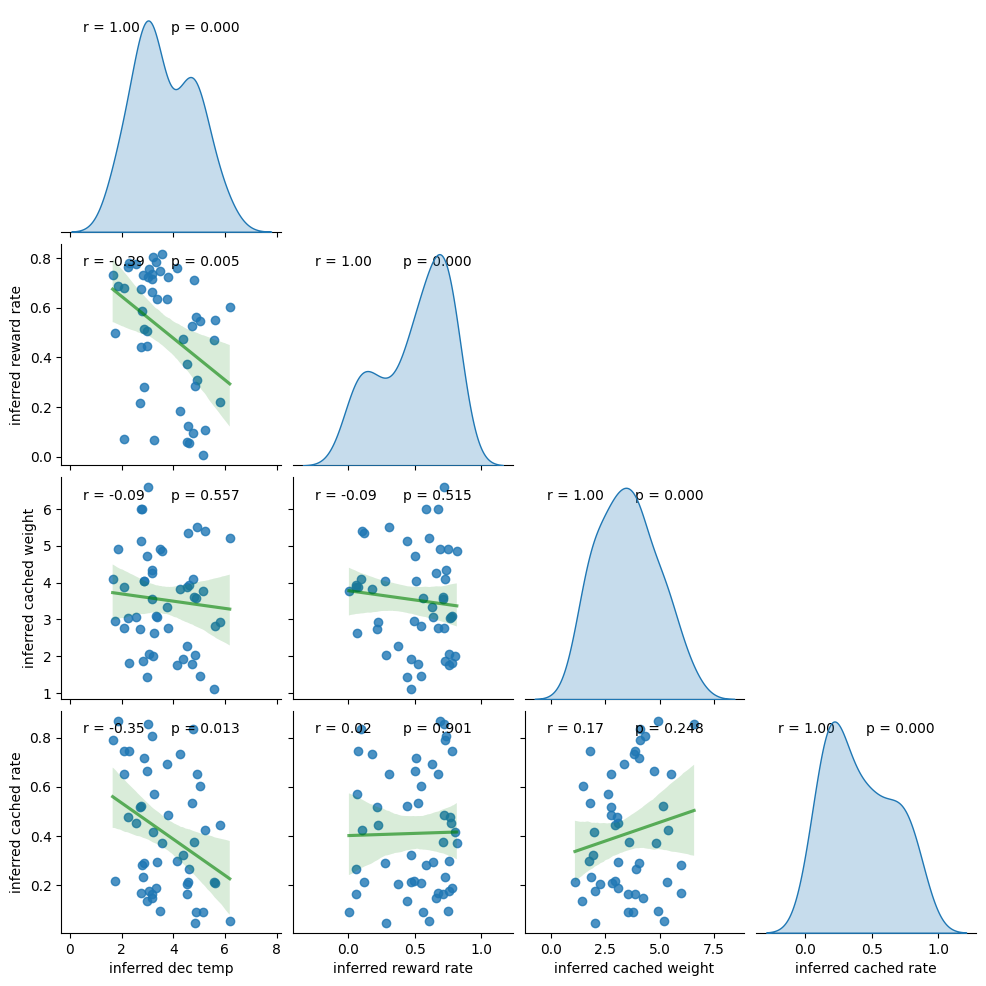

taking steps 501 to 600 out of total 600


Mean ELBO 12155.90: 100%|██████████| 100/100 [20:09<00:00, 12.10s/it]


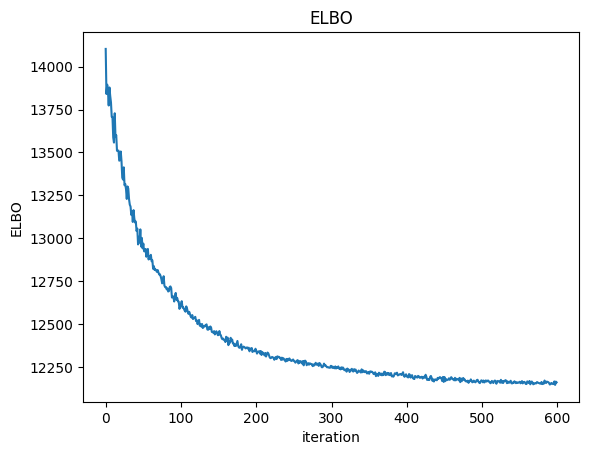

       reward rate  dec temp  cached weight  cached rate  subject
0         0.210379  2.967280       2.194454     0.653590        0
1         0.944745  7.211493       3.170786     0.140039        1
2         0.427264  2.291290       1.665480     0.065233        2
3         0.057543  4.226479       3.497179     0.132259        3
4         0.859272  2.768817       4.702008     0.867210        4
...            ...       ...            ...          ...      ...
24995     0.672139  4.668791       3.774129     0.504524       45
24996     0.879865  1.471044       3.630708     0.787065       46
24997     0.947167  5.392570       1.313725     0.570712       47
24998     0.823238  6.168426       1.003837     0.390519       48
24999     0.104616  3.782257       4.527846     0.466149       49

[25000 rows x 5 columns]


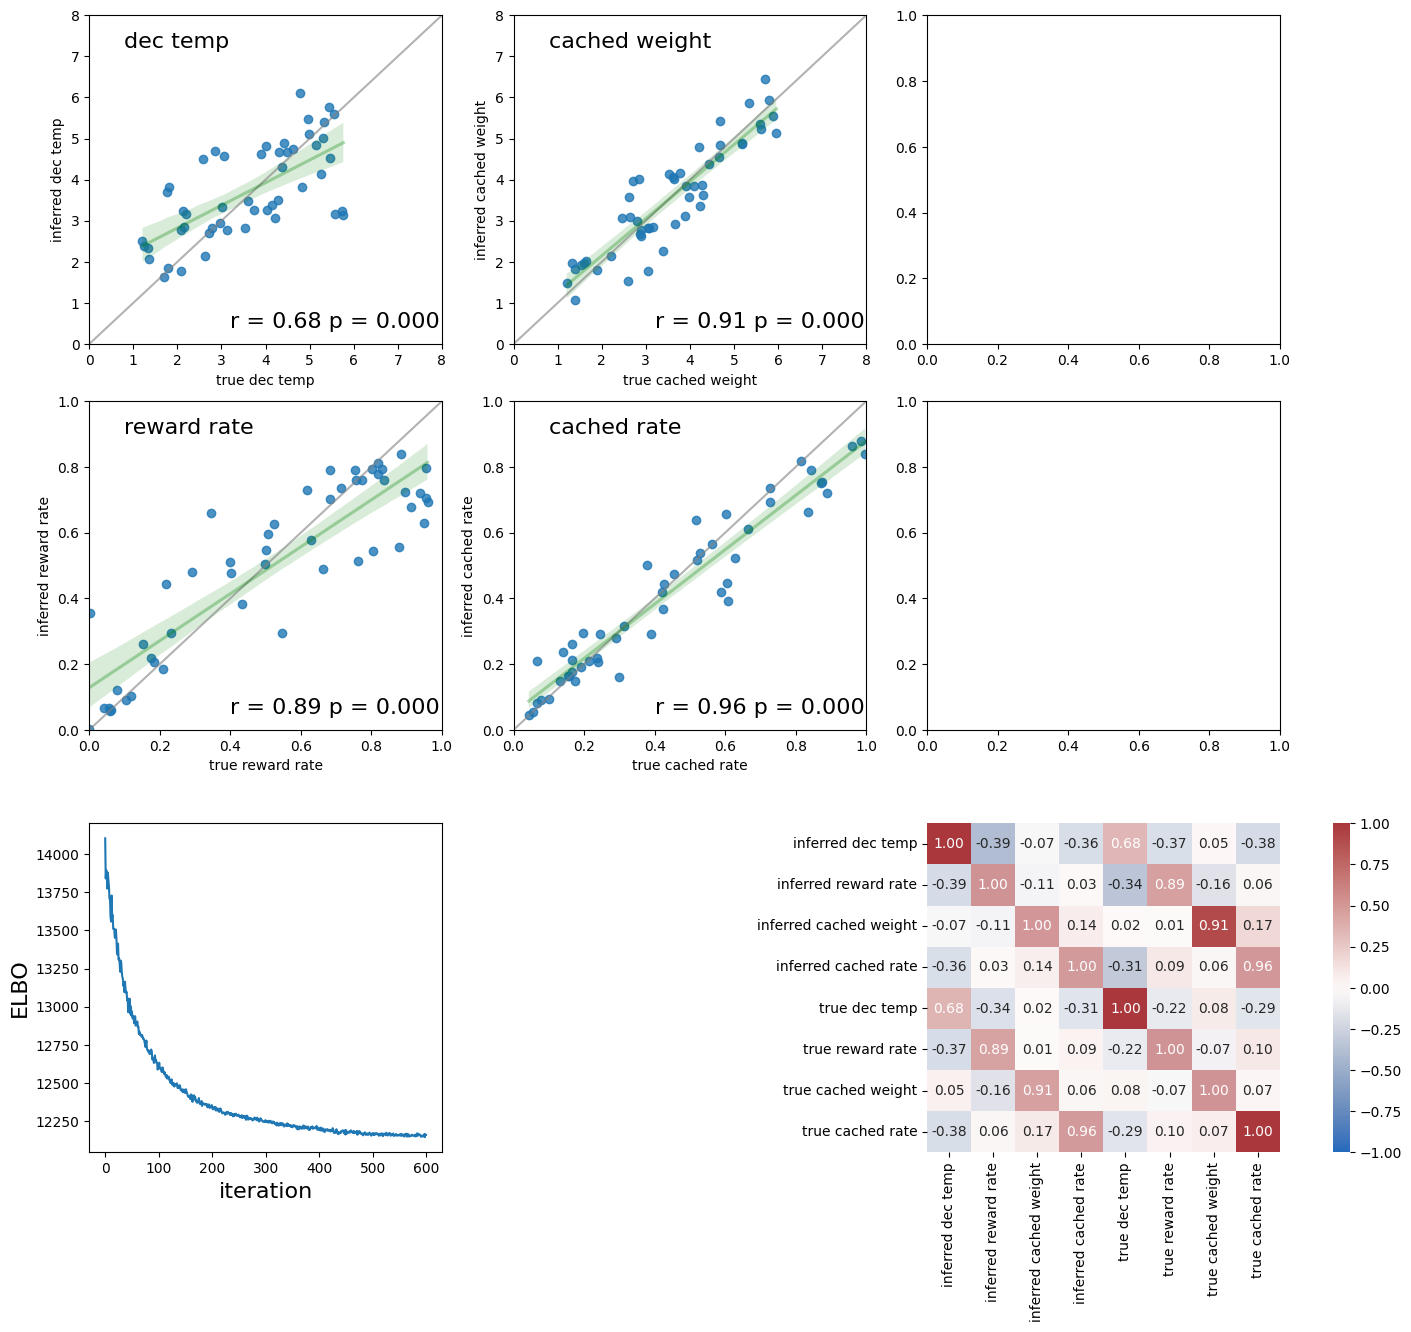

<Figure size 640x480 with 0 Axes>

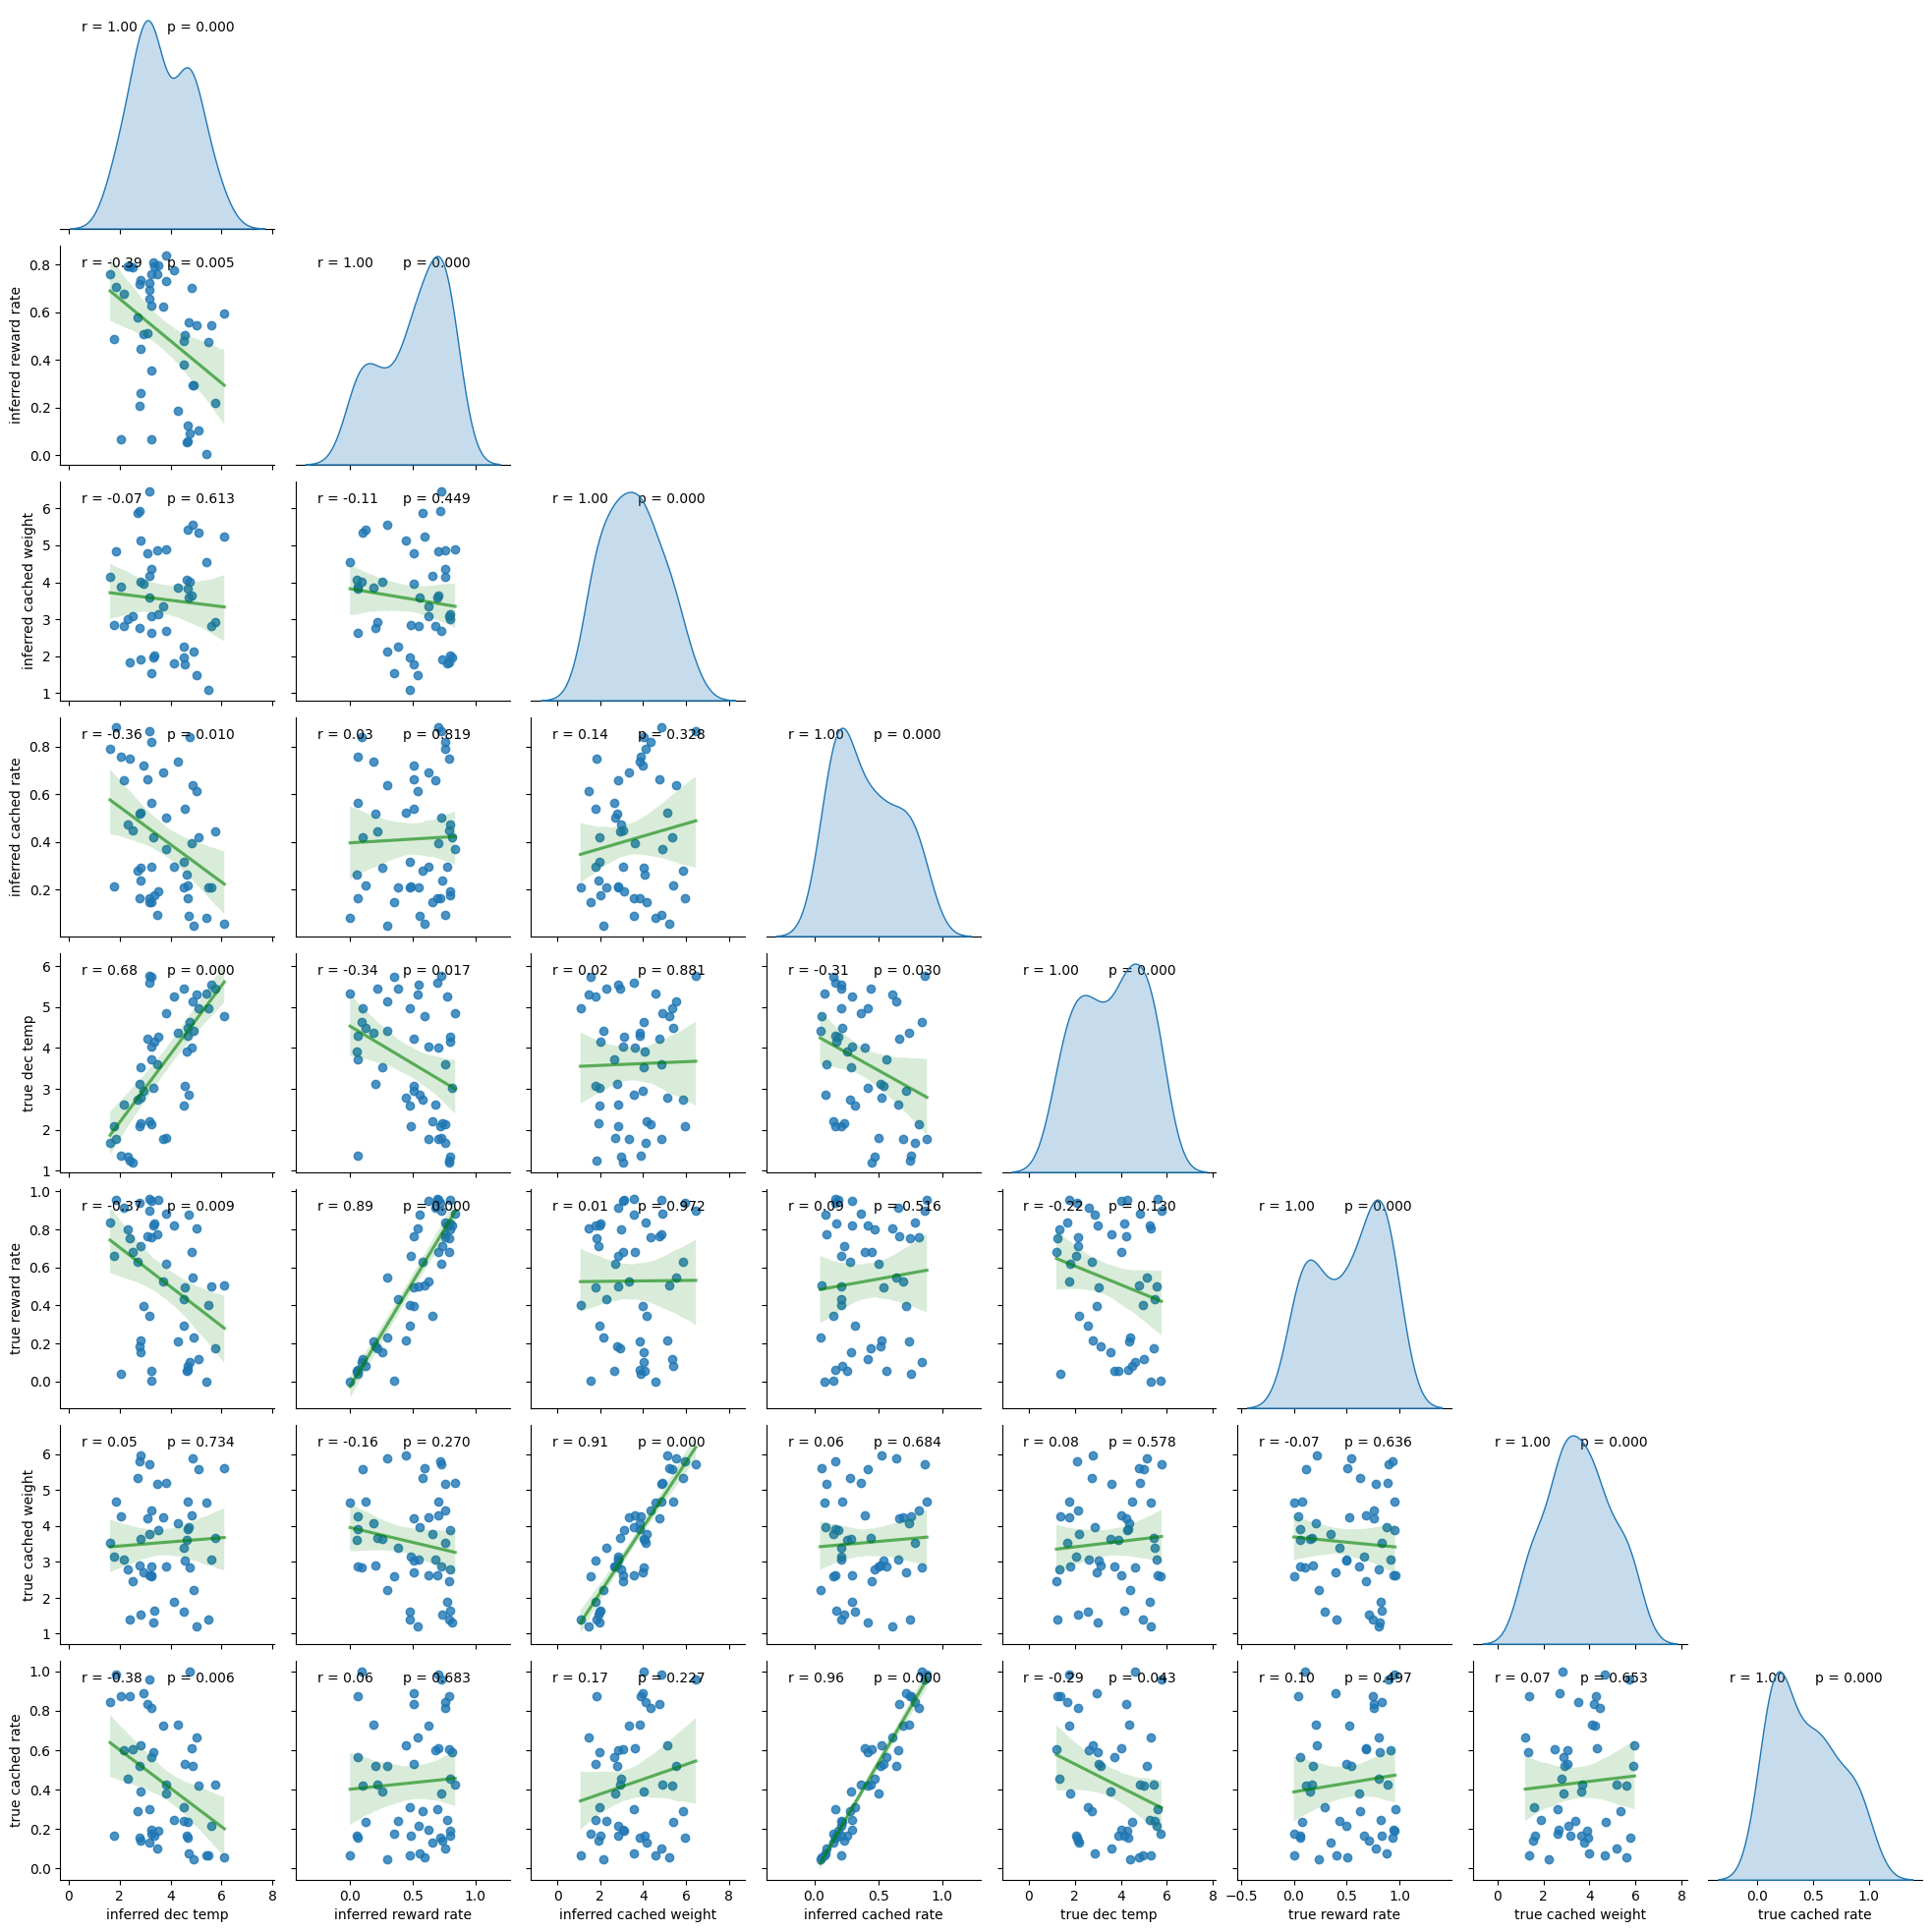

<Figure size 640x480 with 0 Axes>

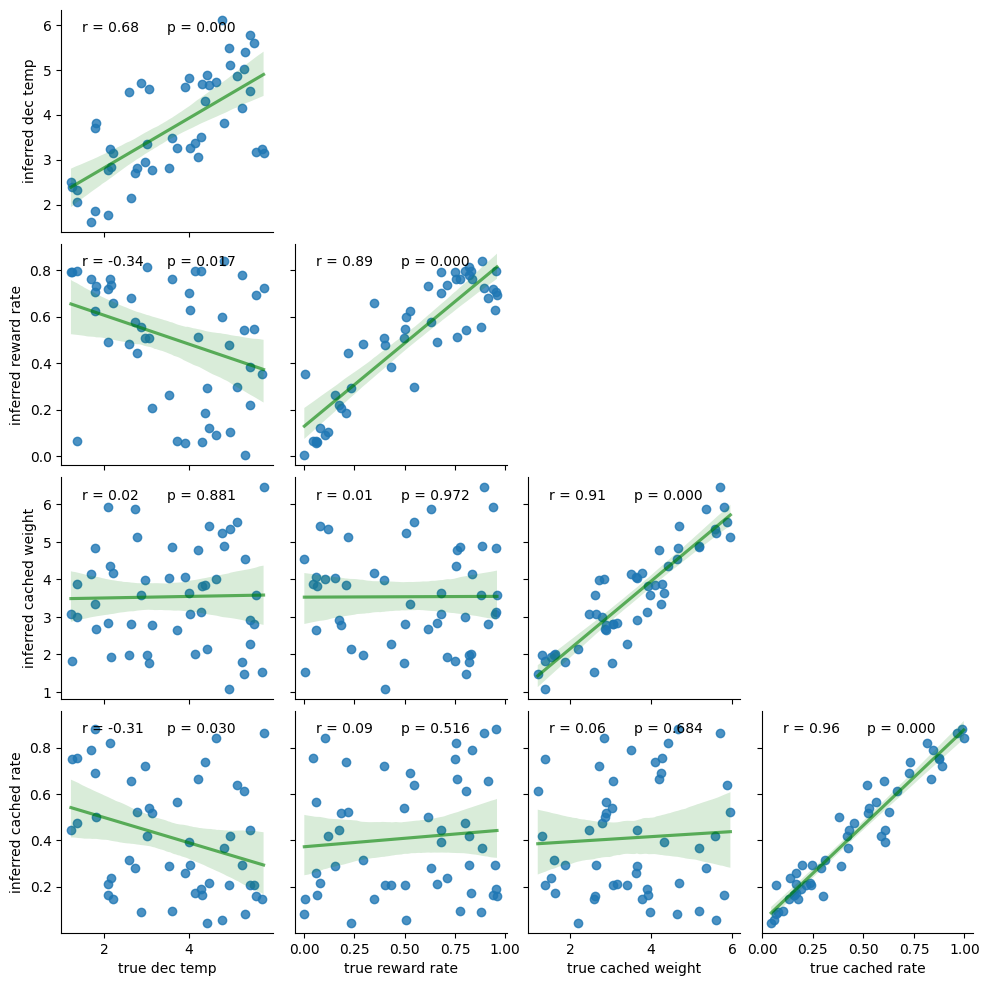

<Figure size 640x480 with 0 Axes>

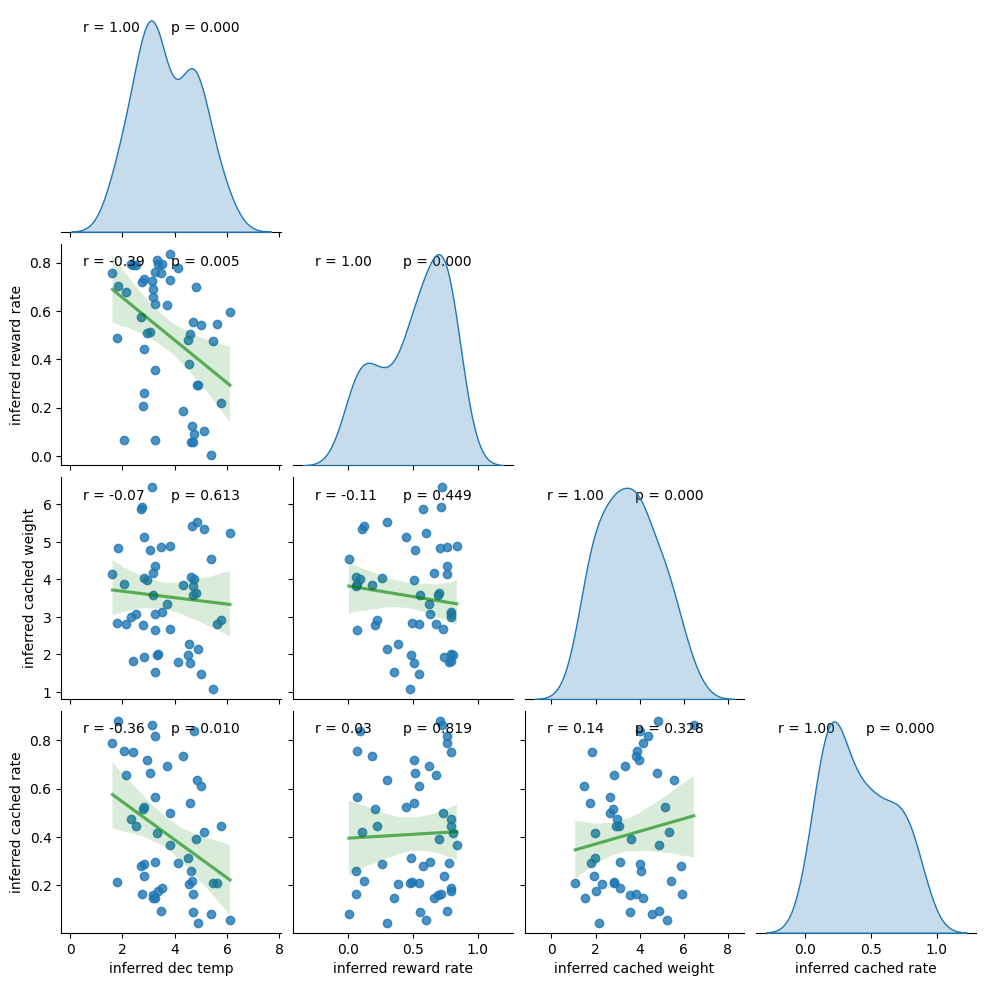

In [28]:
if run_inference:

    # remove old inference?
    remove_old = True

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old, use_h=use_h)

    print('analyzing '+str(n_agents)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 100
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_agents)+'agents'

        iu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir, true_vals=true_vals) 
        iu.plot_results(sample_df, param_names, fname_str, inferrer.loss, mean_df, base_dir, param_ranges)

<b>Or:</b> Set up agent and inference. Load past inference, decide whether to resample posterior or used stored samples

In [29]:

if not run_inference:

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old, use_h=use_h)

    print('analyzing '+str(n_agents)+' data sets')

    resample = True

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir, true_vals=true_vals) 
    else:
        mean_df, sample_df, locs_df = iu.load_samples(base_dir, fname_str) 


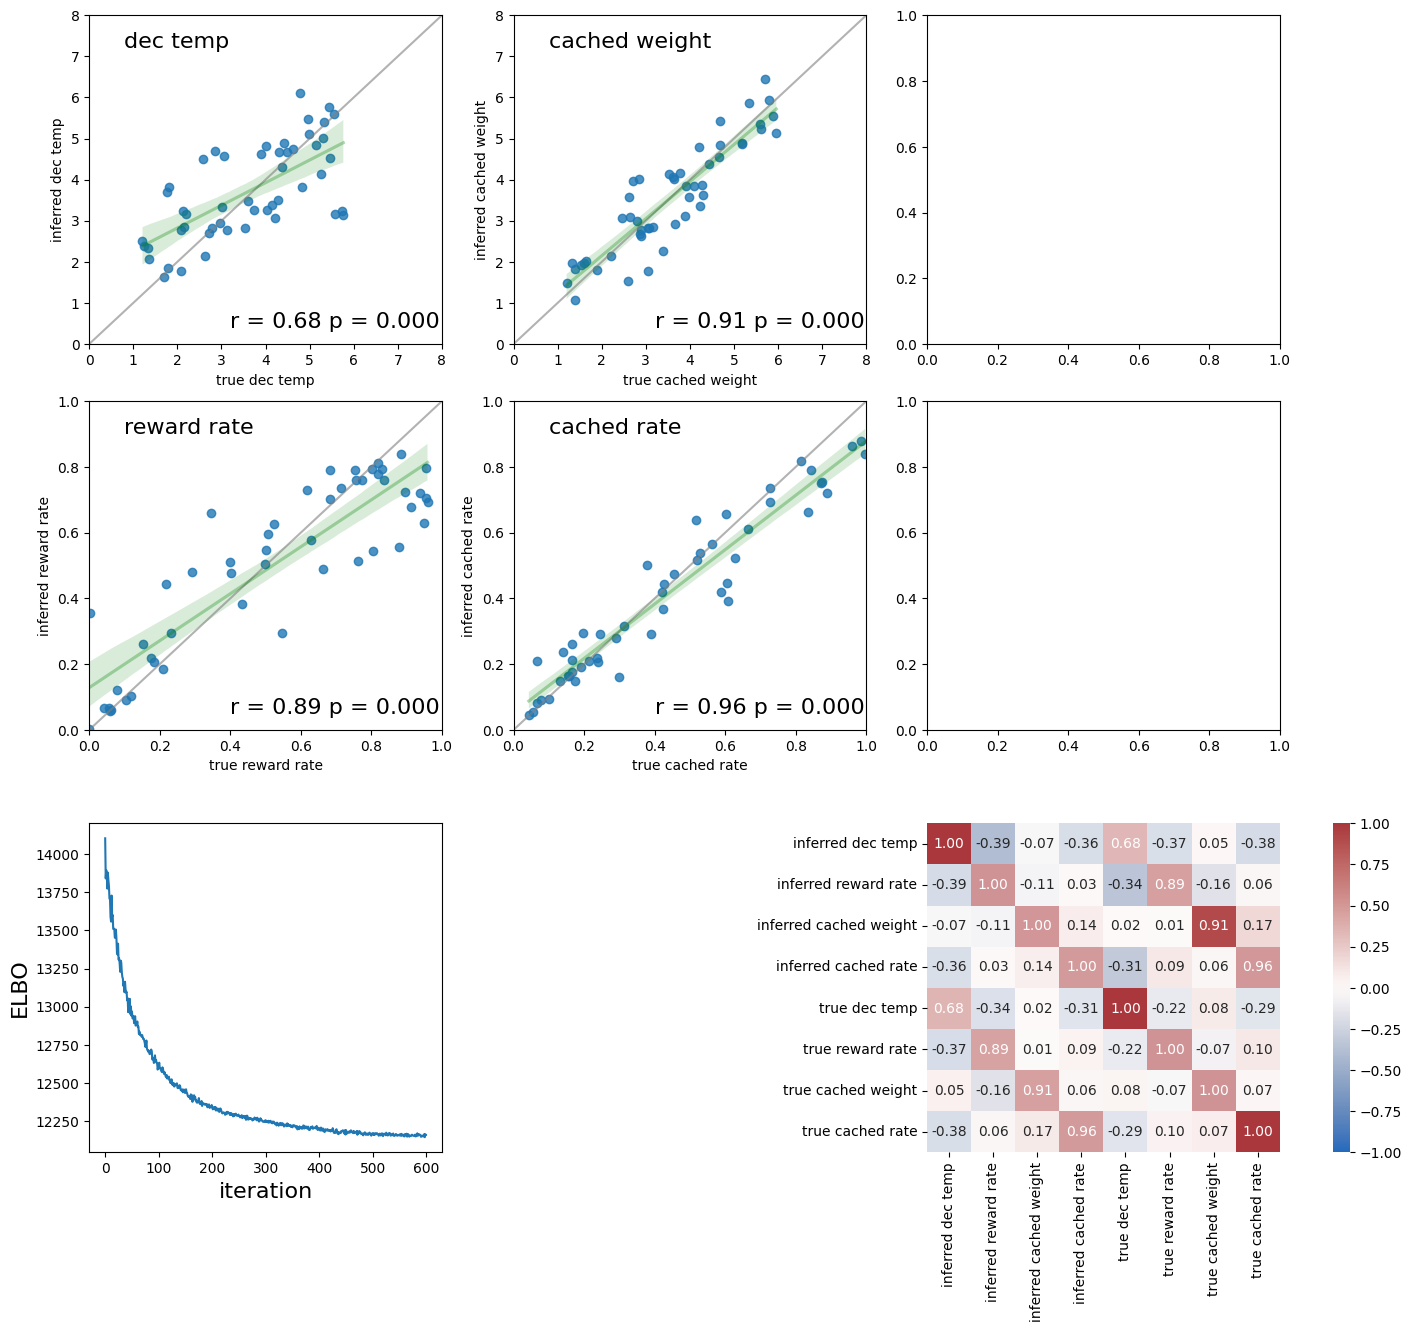

<Figure size 640x480 with 0 Axes>

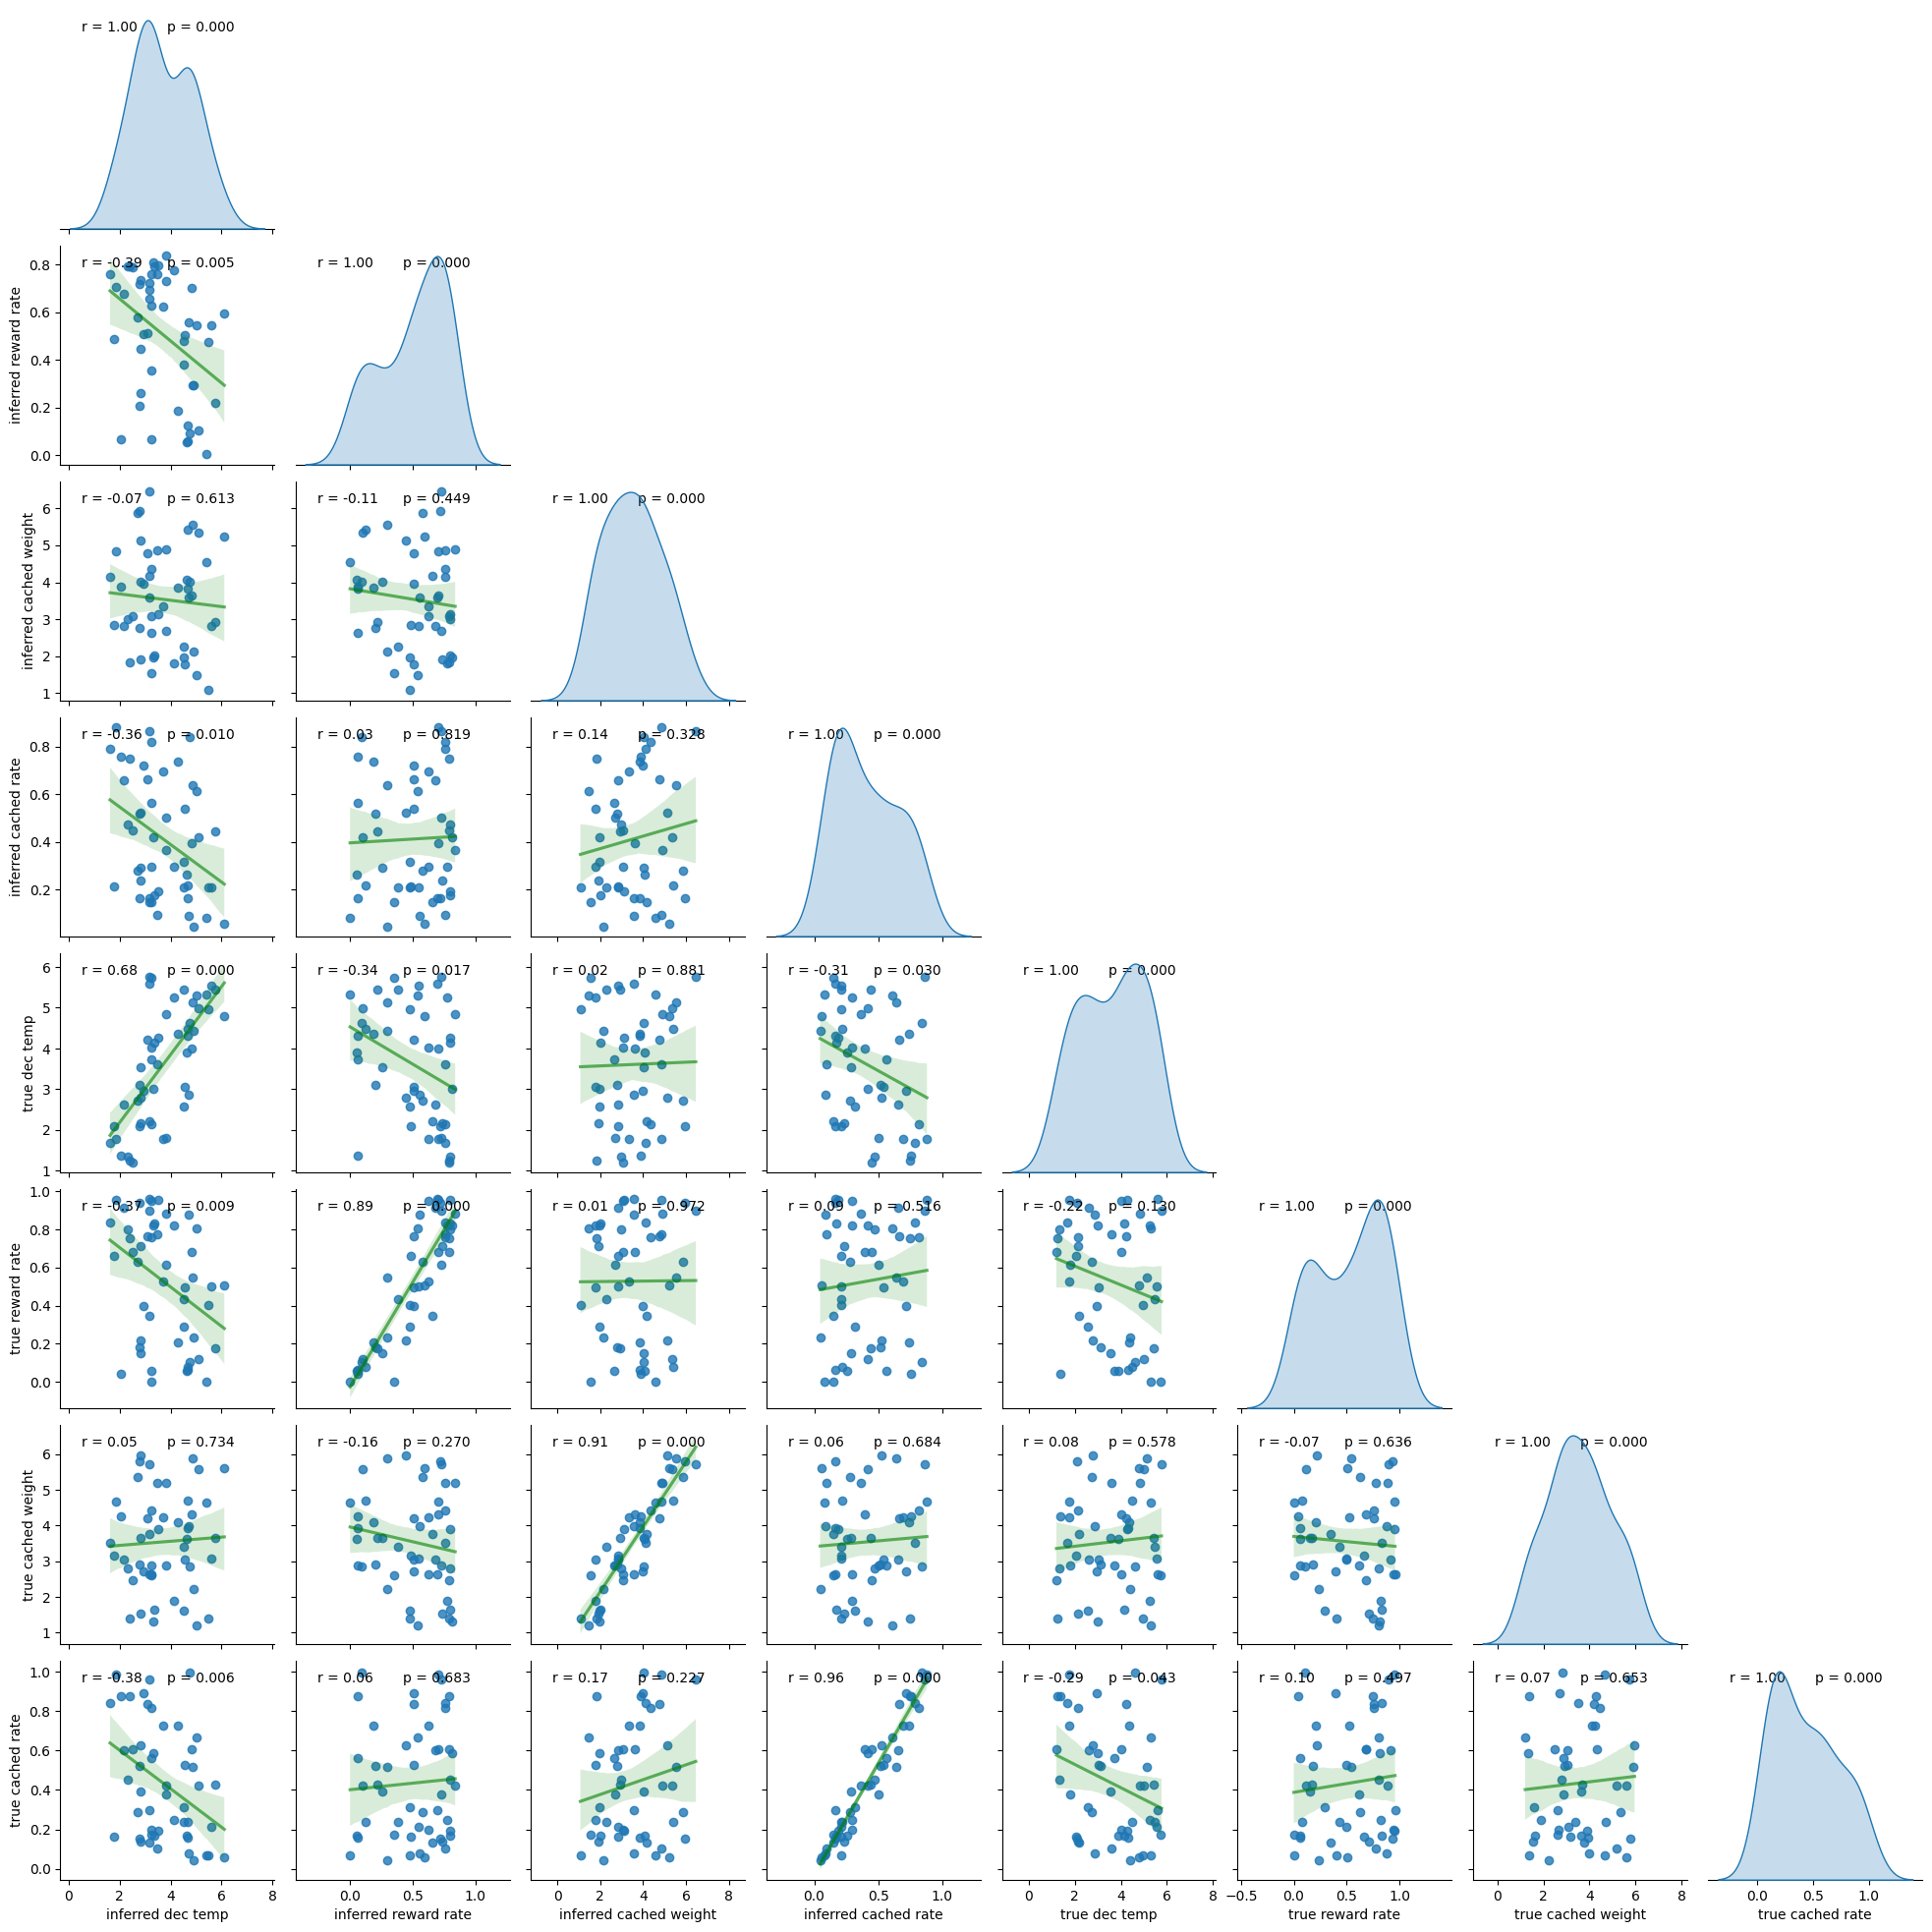

<Figure size 640x480 with 0 Axes>

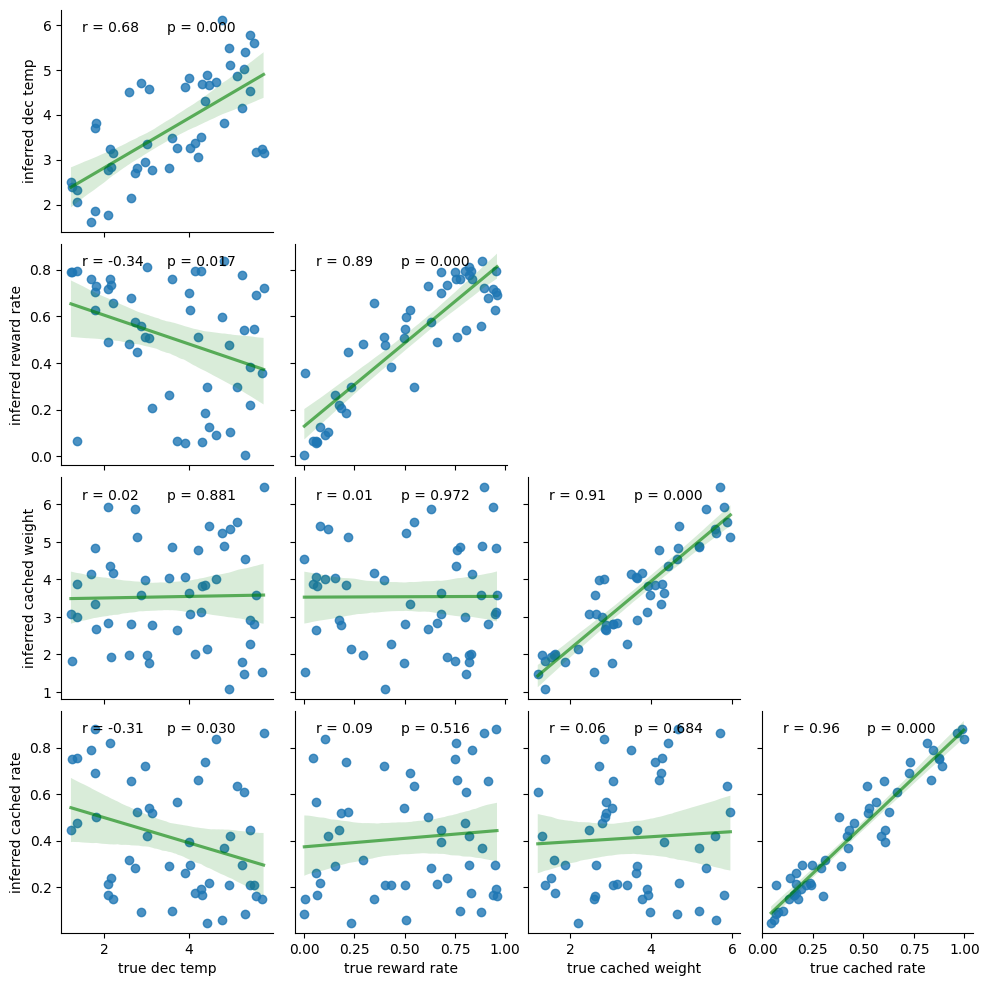

<Figure size 640x480 with 0 Axes>

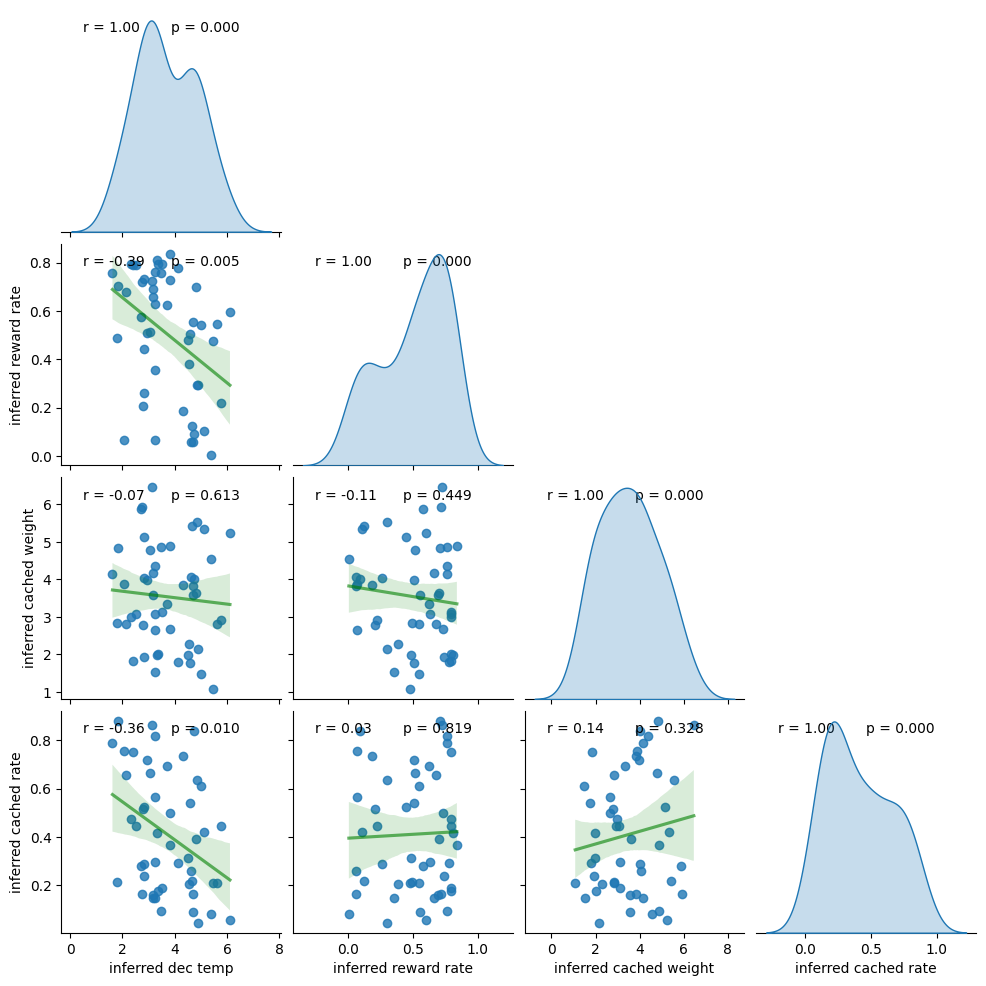

This is recovery for the twostage task using the Bayesian prior-based contextual control model(BCC_4pars_plan_cached) with 50 agents.
The settings are: learn habit - False


In [30]:
iu.plot_results(sample_df, param_names, fname_str, inferrer.loss, mean_df, base_dir, param_ranges)
        
print("This is recovery for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: learn habit - "+str(learn_habit))